# Tree-Based Methods

Decision trees and ensemble methods for classification and regression.

## Contents
1. Classification Trees
2. Tree Pruning with Cross-Validation
3. Regression Trees
4. Bagging (Bootstrap Aggregation)
5. Random Forests
6. Boosting (Gradient Boosting)

## Setup and Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 1. Classification Trees

Predict whether sales are High (>8) or Low (<=8) using Carseats dataset.

In [3]:
# Load Carseats dataset
url = "https://raw.githubusercontent.com/selva86/datasets/master/Carseats.csv"
Carseats = pd.read_csv(url)

print(f"Dataset shape: {Carseats.shape}")
print(f"\nColumn names:")
print(Carseats.columns.tolist())
print(f"\nFirst few rows:")
Carseats.head()

Dataset shape: (400, 11)

Column names:
['Sales', 'CompPrice', 'Income', 'Advertising', 'Population', 'Price', 'ShelveLoc', 'Age', 'Education', 'Urban', 'US']

First few rows:


Sales  CompPrice  Income  Advertising  Population  Price ShelveLoc  Age  \
0   9.50        138      73           11         276    120       Bad   42   
1  11.22        111      48           16         260     83      Good   65   
2  10.06        113      35           10         269     80    Medium   59   
3   7.40        117     100            4         466     97    Medium   55   
4   4.15        141      64            3         340    128       Bad   38   

   Education Urban   US  
0         17   Yes  Yes  
1         10   Yes  Yes  
2         12   Yes  Yes  
3         14   Yes  Yes  
4         13   Yes   No

In [4]:
# Create binary target: High = 'Yes' if Sales > 8, else 'No'
Carseats['High'] = np.where(Carseats['Sales'] > 8, 'Yes', 'No')

print("Distribution of High:")
print(Carseats['High'].value_counts())
print(f"\nPercentage High: {(Carseats['High'] == 'Yes').mean()*100:.1f}%")

Distribution of High:
High
No     236
Yes    164
Name: count, dtype: int64

Percentage High: 41.0%


In [5]:
# Prepare data for classification
# Drop Sales (used to create target) and High (target)
X = Carseats.drop(['Sales', 'High'], axis=1)
y = Carseats['High']

# Convert categorical variables to dummy variables
X = pd.get_dummies(X, drop_first=True)

print(f"Features: {X.shape[1]}")
print(f"Feature names: {X.columns.tolist()}")

Features: 11
Feature names: ['CompPrice', 'Income', 'Advertising', 'Population', 'Price', 'Age', 'Education', 'ShelveLoc_Good', 'ShelveLoc_Medium', 'Urban_Yes', 'US_Yes']


In [6]:
# Fit full classification tree
tree_full = DecisionTreeClassifier(random_state=1)
tree_full.fit(X, y)

print("Full Classification Tree:")
print(f"Number of leaves: {tree_full.get_n_leaves()}")
print(f"Max depth: {tree_full.get_depth()}")
print(f"Training accuracy: {tree_full.score(X, y):.4f}")

Full Classification Tree:
Number of leaves: 61
Max depth: 11
Training accuracy: 1.0000


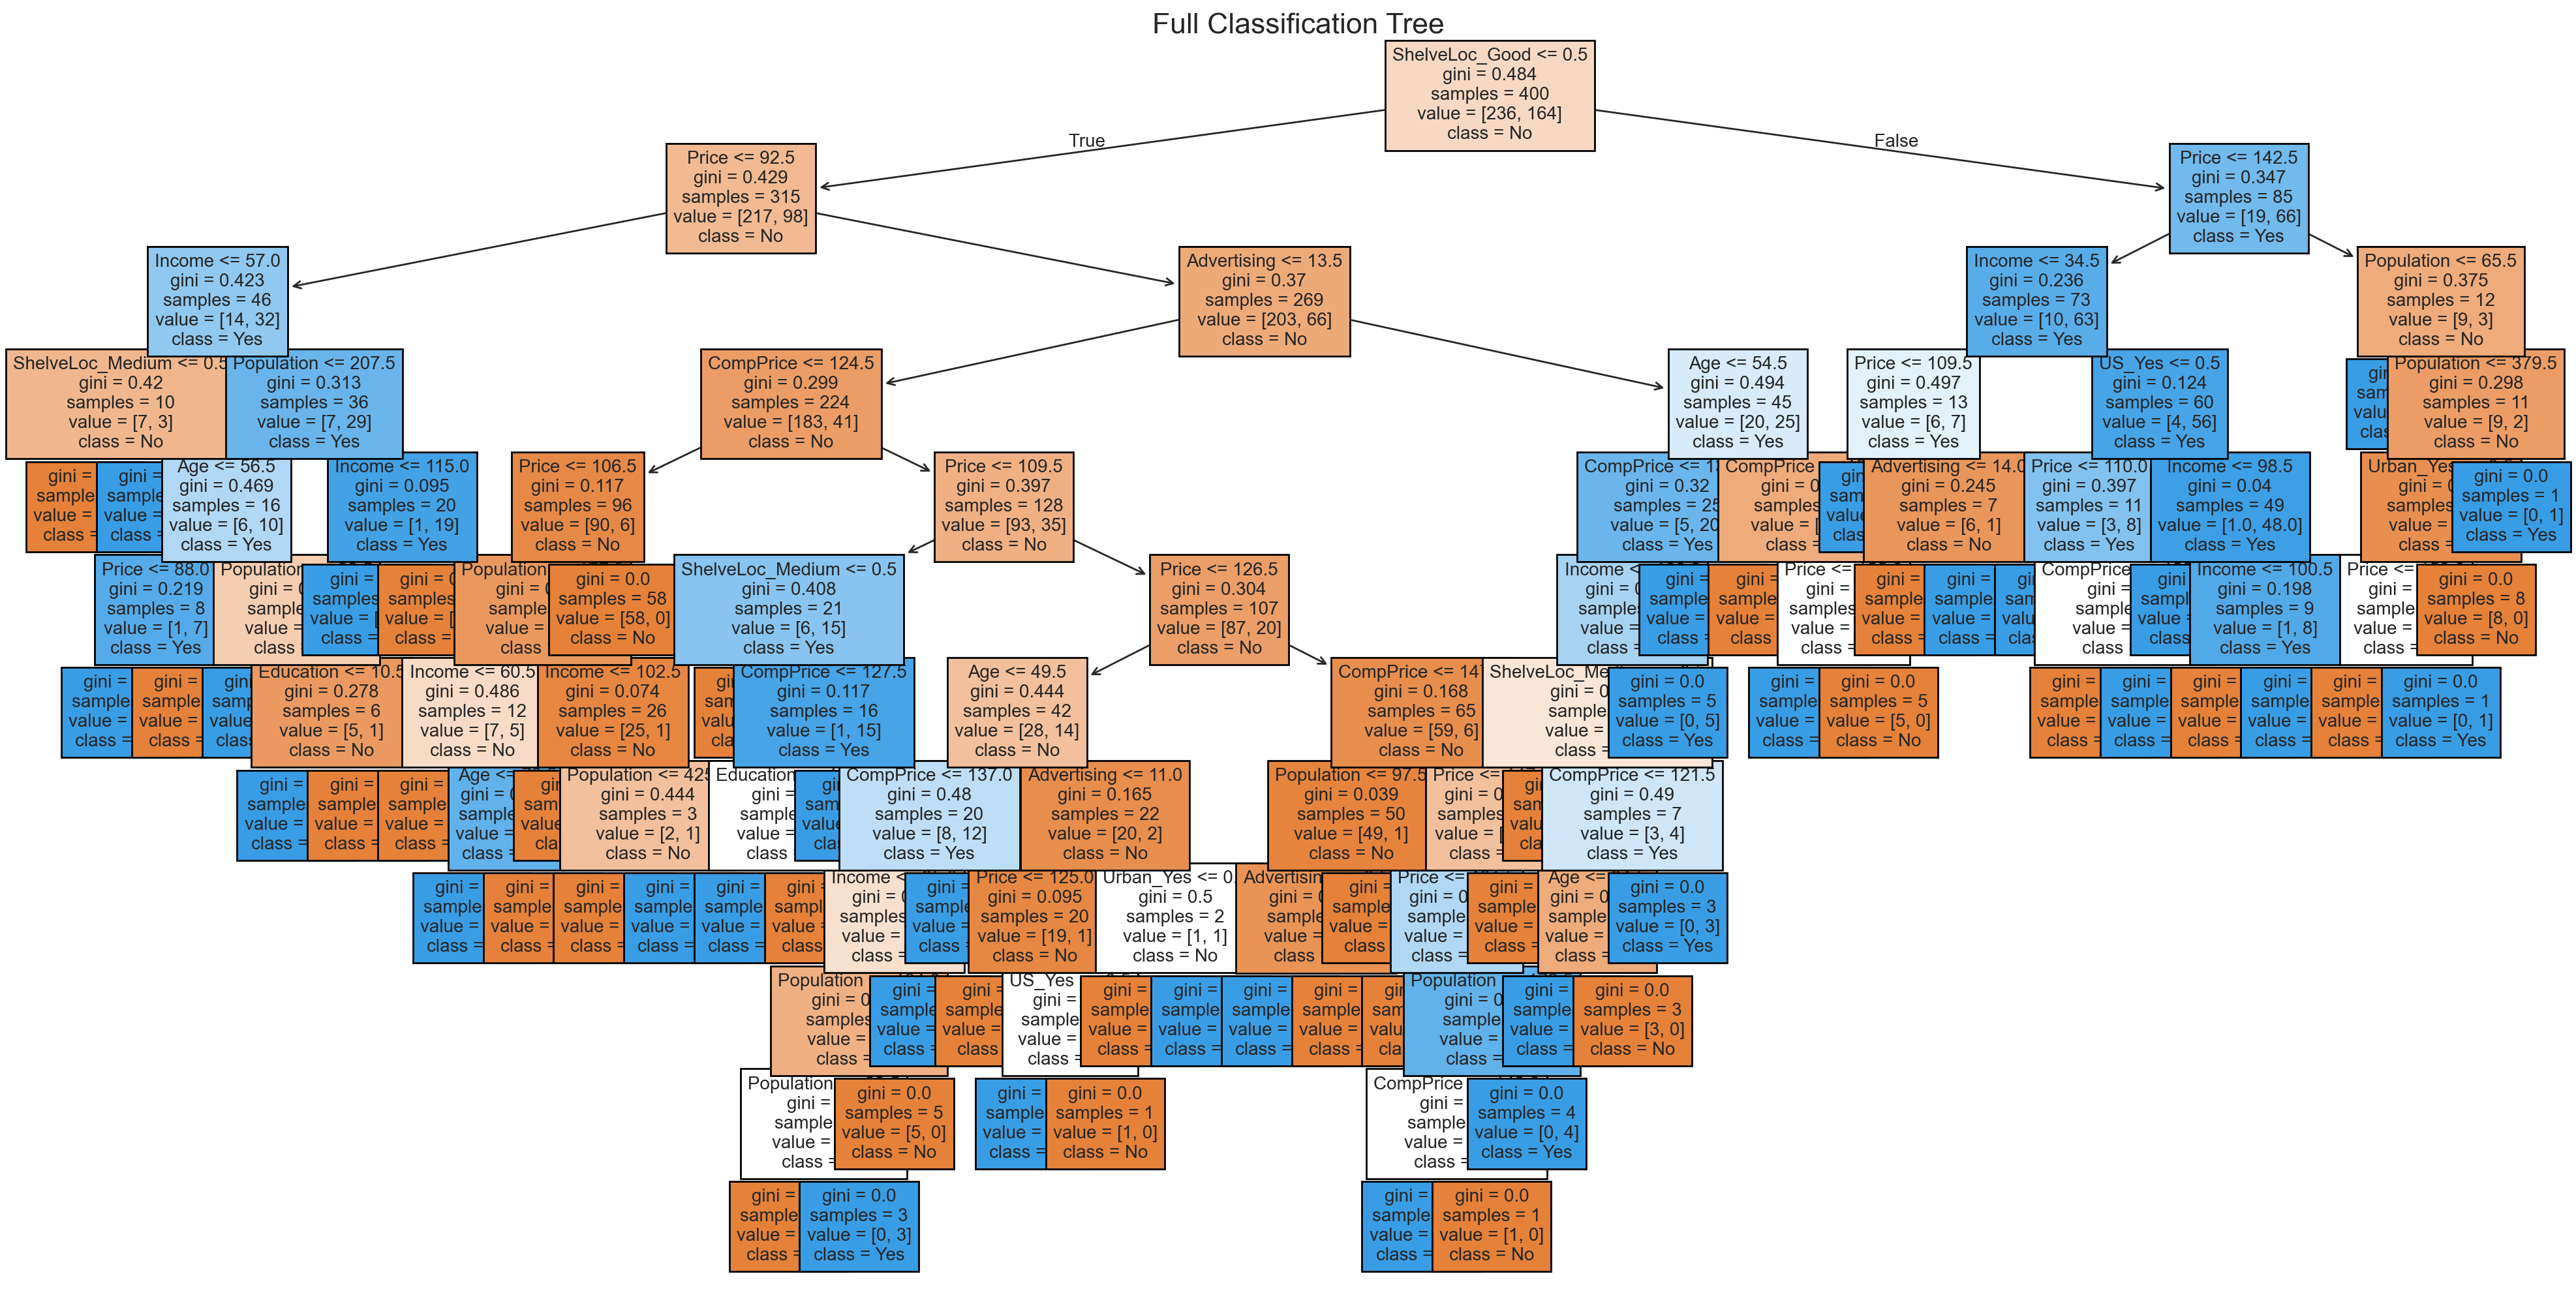

Tree is very deep and complex (likely overfitting)


In [7]:
# Visualize the tree
plt.figure(figsize=(20, 10))
plot_tree(tree_full, 
          feature_names=X.columns,
          class_names=['No', 'Yes'],
          filled=True,
          fontsize=10)
plt.title('Full Classification Tree', fontsize=16)
plt.tight_layout()
plt.show()

print("Tree is very deep and complex (likely overfitting)")

### Train/Test Split Evaluation

In [8]:
# Split data: 200 train, 200 test
np.random.seed(2)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=200, random_state=2)

print(f"Training set: {len(X_train)}")
print(f"Test set: {len(X_test)}")

Training set: 200
Test set: 200


In [9]:
# Fit tree on training data
tree_train = DecisionTreeClassifier(random_state=1)
tree_train.fit(X_train, y_train)

# Predict on test set
y_pred = tree_train.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("Confusion Matrix:")
print(pd.DataFrame(cm, 
                   index=['Actual: No', 'Actual: Yes'],
                   columns=['Predicted: No', 'Predicted: Yes']))
print(f"\nTest Accuracy: {accuracy:.4f} ({accuracy*100:.1f}%)")
print(f"Test Error Rate: {1-accuracy:.4f} ({(1-accuracy)*100:.1f}%)")

Confusion Matrix:
             Predicted: No  Predicted: Yes
Actual: No              96              30
Actual: Yes             17              57

Test Accuracy: 0.7650 (76.5%)
Test Error Rate: 0.2350 (23.5%)


## 2. Tree Pruning with Cross-Validation

Use cost complexity pruning to find optimal tree size.

In [10]:
# Get cost complexity pruning path
path = tree_train.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
impurities = path.impurities

print(f"Number of alpha values: {len(ccp_alphas)}")
print(f"Alpha range: {ccp_alphas.min():.6f} to {ccp_alphas.max():.6f}")

Number of alpha values: 19
Alpha range: 0.000000 to 0.070313


In [11]:
# Train trees with different alpha values
trees = []
for ccp_alpha in ccp_alphas:
    tree = DecisionTreeClassifier(random_state=1, ccp_alpha=ccp_alpha)
    tree.fit(X_train, y_train)
    trees.append(tree)

print(f"Total number of trees: {len(trees)}")
print(f"\nTree sizes (number of nodes):")
print(f"  Min: {min(tree.tree_.node_count for tree in trees)}")
print(f"  Max: {max(tree.tree_.node_count for tree in trees)}")

Total number of trees: 19

Tree sizes (number of nodes):
  Min: 1
  Max: 71


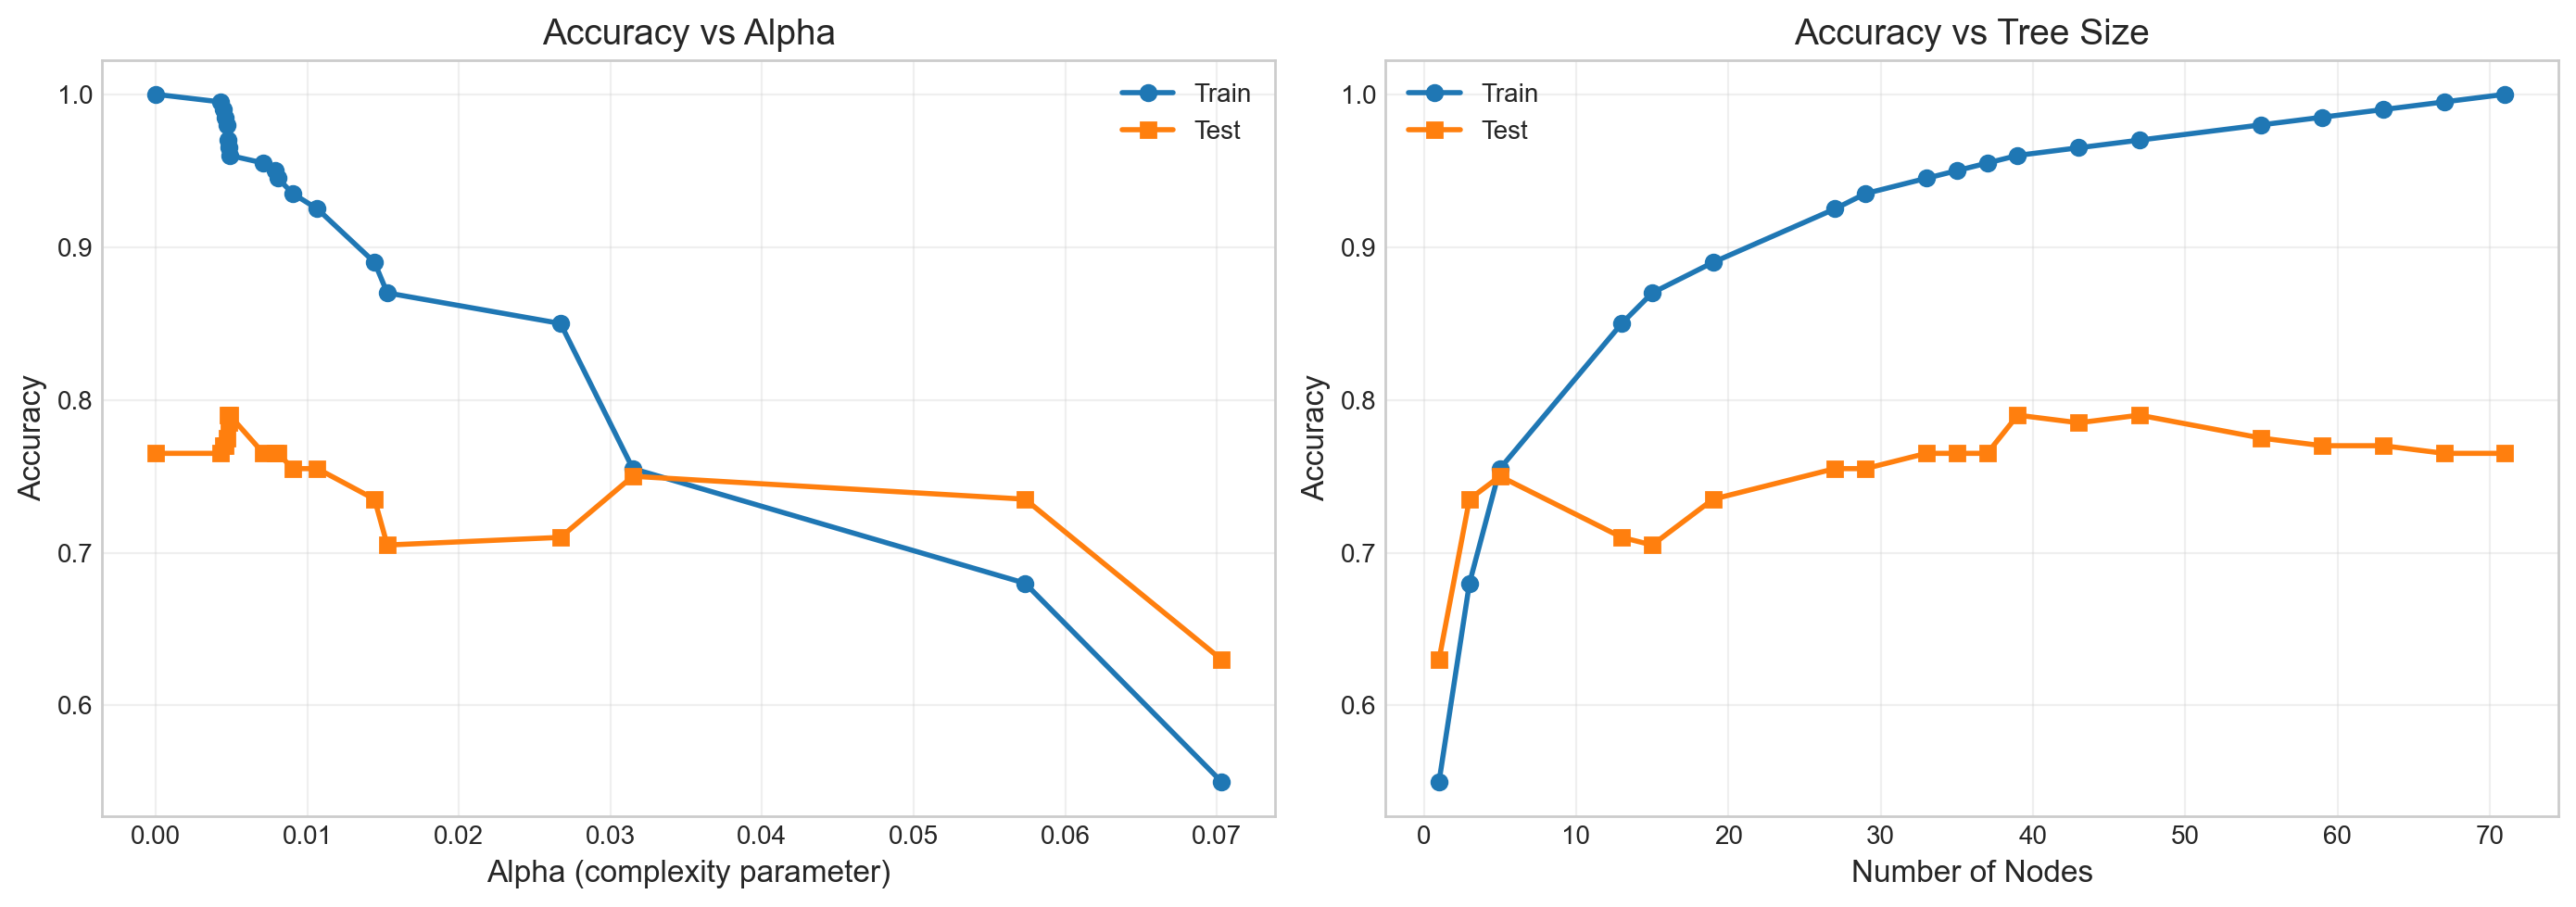


Best tree:
  Alpha: 0.004744
  Nodes: 47
  Test Accuracy: 0.7900


In [12]:
# Calculate training and test accuracy for each tree
train_scores = [tree.score(X_train, y_train) for tree in trees]
test_scores = [tree.score(X_test, y_test) for tree in trees]
node_counts = [tree.tree_.node_count for tree in trees]
depth = [tree.tree_.max_depth for tree in trees]

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Alpha vs Accuracy
axes[0].plot(ccp_alphas, train_scores, marker='o', label='Train', linewidth=2)
axes[0].plot(ccp_alphas, test_scores, marker='s', label='Test', linewidth=2)
axes[0].set_xlabel('Alpha (complexity parameter)', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Accuracy vs Alpha', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Tree size vs Accuracy
axes[1].plot(node_counts, train_scores, marker='o', label='Train', linewidth=2)
axes[1].plot(node_counts, test_scores, marker='s', label='Test', linewidth=2)
axes[1].set_xlabel('Number of Nodes', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Accuracy vs Tree Size', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find best alpha
best_idx = np.argmax(test_scores)
best_alpha = ccp_alphas[best_idx]
best_score = test_scores[best_idx]
best_nodes = node_counts[best_idx]

print(f"\nBest tree:")
print(f"  Alpha: {best_alpha:.6f}")
print(f"  Nodes: {best_nodes}")
print(f"  Test Accuracy: {best_score:.4f}")

In [13]:
# Fit pruned tree with best alpha
tree_pruned = DecisionTreeClassifier(random_state=1, ccp_alpha=best_alpha)
tree_pruned.fit(X_train, y_train)

# Evaluate pruned tree
y_pred_pruned = tree_pruned.predict(X_test)
accuracy_pruned = accuracy_score(y_test, y_pred_pruned)

print("Pruned Tree Performance:")
print(f"Number of leaves: {tree_pruned.get_n_leaves()}")
print(f"Max depth: {tree_pruned.get_depth()}")
print(f"Test Accuracy: {accuracy_pruned:.4f} ({accuracy_pruned*100:.1f}%)")

# Confusion matrix
cm_pruned = confusion_matrix(y_test, y_pred_pruned)
print("\nConfusion Matrix (Pruned Tree):")
print(pd.DataFrame(cm_pruned,
                   index=['Actual: No', 'Actual: Yes'],
                   columns=['Predicted: No', 'Predicted: Yes']))

Pruned Tree Performance:
Number of leaves: 24
Max depth: 8
Test Accuracy: 0.7900 (79.0%)

Confusion Matrix (Pruned Tree):
             Predicted: No  Predicted: Yes
Actual: No             101              25
Actual: Yes             17              57


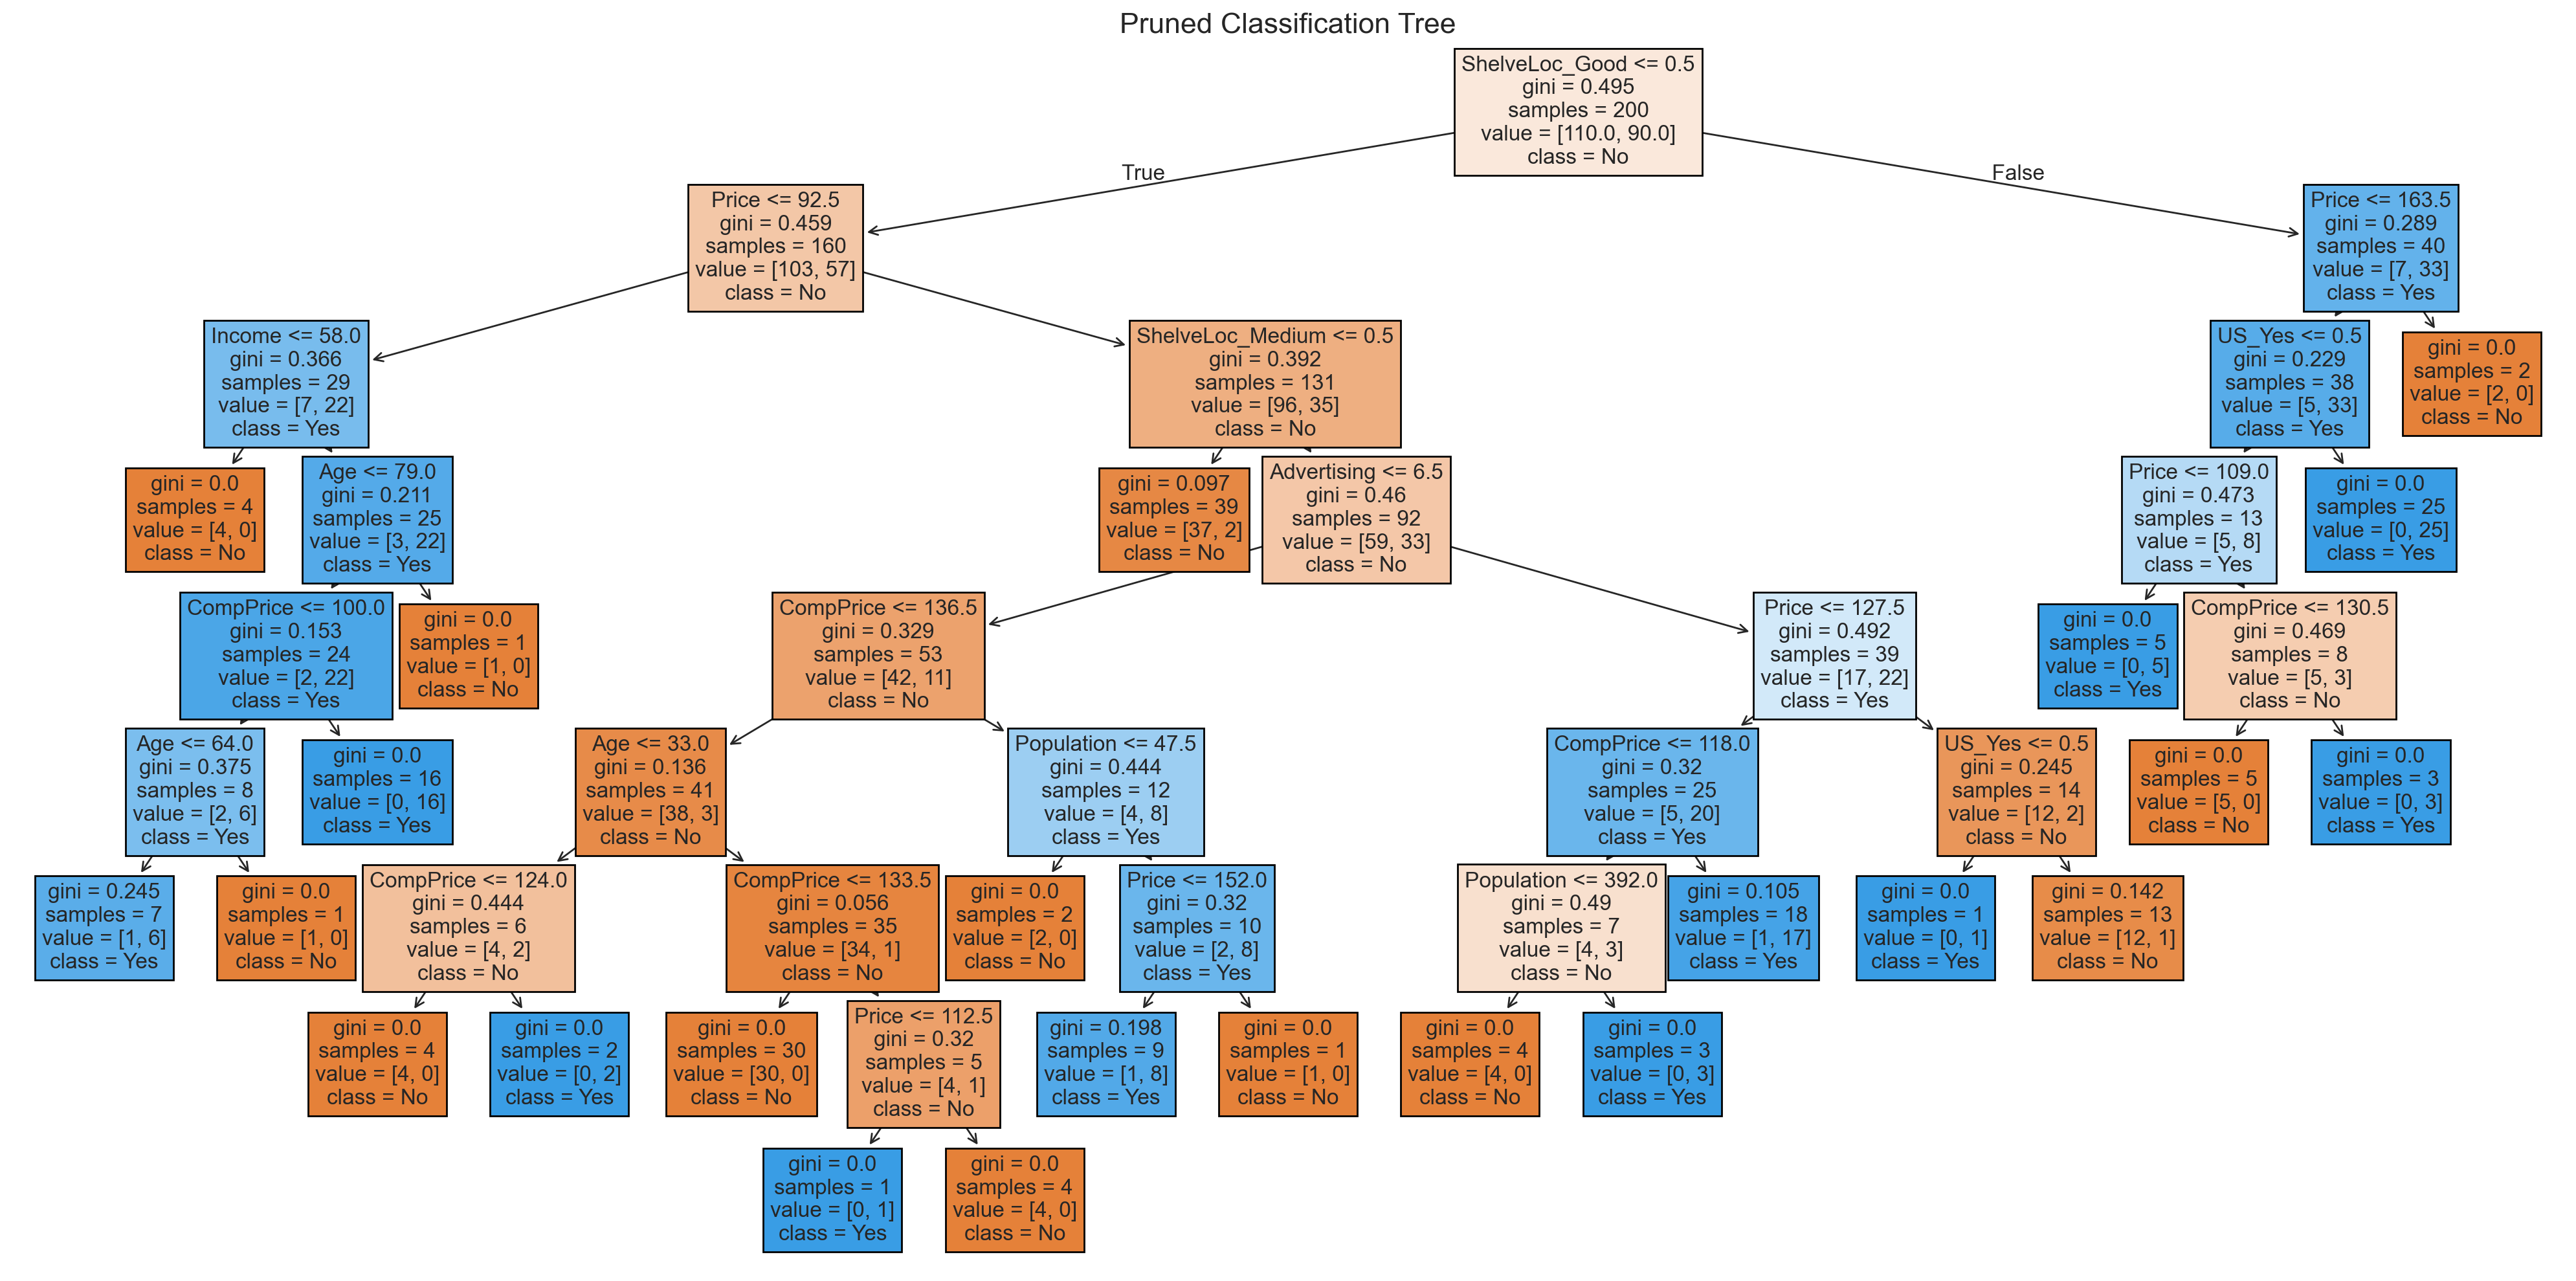

Pruned tree is simpler and more interpretable


In [14]:
# Visualize pruned tree
plt.figure(figsize=(20, 10))
plot_tree(tree_pruned,
          feature_names=X.columns,
          class_names=['No', 'Yes'],
          filled=True,
          fontsize=12)
plt.title('Pruned Classification Tree', fontsize=16)
plt.tight_layout()
plt.show()

print("Pruned tree is simpler and more interpretable")

## 3. Regression Trees

Predict median house value using Boston Housing dataset.

In [15]:
# Load Boston Housing dataset
from sklearn.datasets import fetch_california_housing

# Note: Boston dataset was deprecated, using California housing as alternative
# If you have Boston data locally, load it instead
try:
    url = "https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv"
    Boston = pd.read_csv(url)
    print("Loaded Boston Housing dataset")
except:
    print("Boston dataset not available, using California Housing")
    data = fetch_california_housing()
    Boston = pd.DataFrame(data.data, columns=data.feature_names)
    Boston['medv'] = data.target

print(f"\nDataset shape: {Boston.shape}")
print(f"\nFirst few rows:")
Boston.head()

Loaded Boston Housing dataset

Dataset shape: (506, 14)

First few rows:


crim    zn  indus  chas    nox     rm   age     dis  rad  tax  ptratio  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7   

        b  lstat  medv  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90   5.33  36.2

In [16]:
# Prepare data
X_boston = Boston.drop('medv', axis=1)
y_boston = Boston['medv']

# Split data: 50% train, 50% test
np.random.seed(1)
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X_boston, y_boston, test_size=0.5, random_state=1
)

print(f"Training set: {len(X_train_b)}")
print(f"Test set: {len(X_test_b)}")

Training set: 253
Test set: 253


In [17]:
# Fit regression tree
tree_boston = DecisionTreeRegressor(random_state=1)
tree_boston.fit(X_train_b, y_train_b)

print("Regression Tree:")
print(f"Number of leaves: {tree_boston.get_n_leaves()}")
print(f"Max depth: {tree_boston.get_depth()}")

# Predictions
y_pred_train = tree_boston.predict(X_train_b)
y_pred_test = tree_boston.predict(X_test_b)

# MSE
mse_train = mean_squared_error(y_train_b, y_pred_train)
mse_test = mean_squared_error(y_test_b, y_pred_test)

print(f"\nTraining MSE: {mse_train:.4f}")
print(f"Test MSE: {mse_test:.4f}")
print(f"Test RMSE: ${np.sqrt(mse_test):.2f}")

Regression Tree:
Number of leaves: 242
Max depth: 17

Training MSE: 0.0000
Test MSE: 22.3351
Test RMSE: $4.73


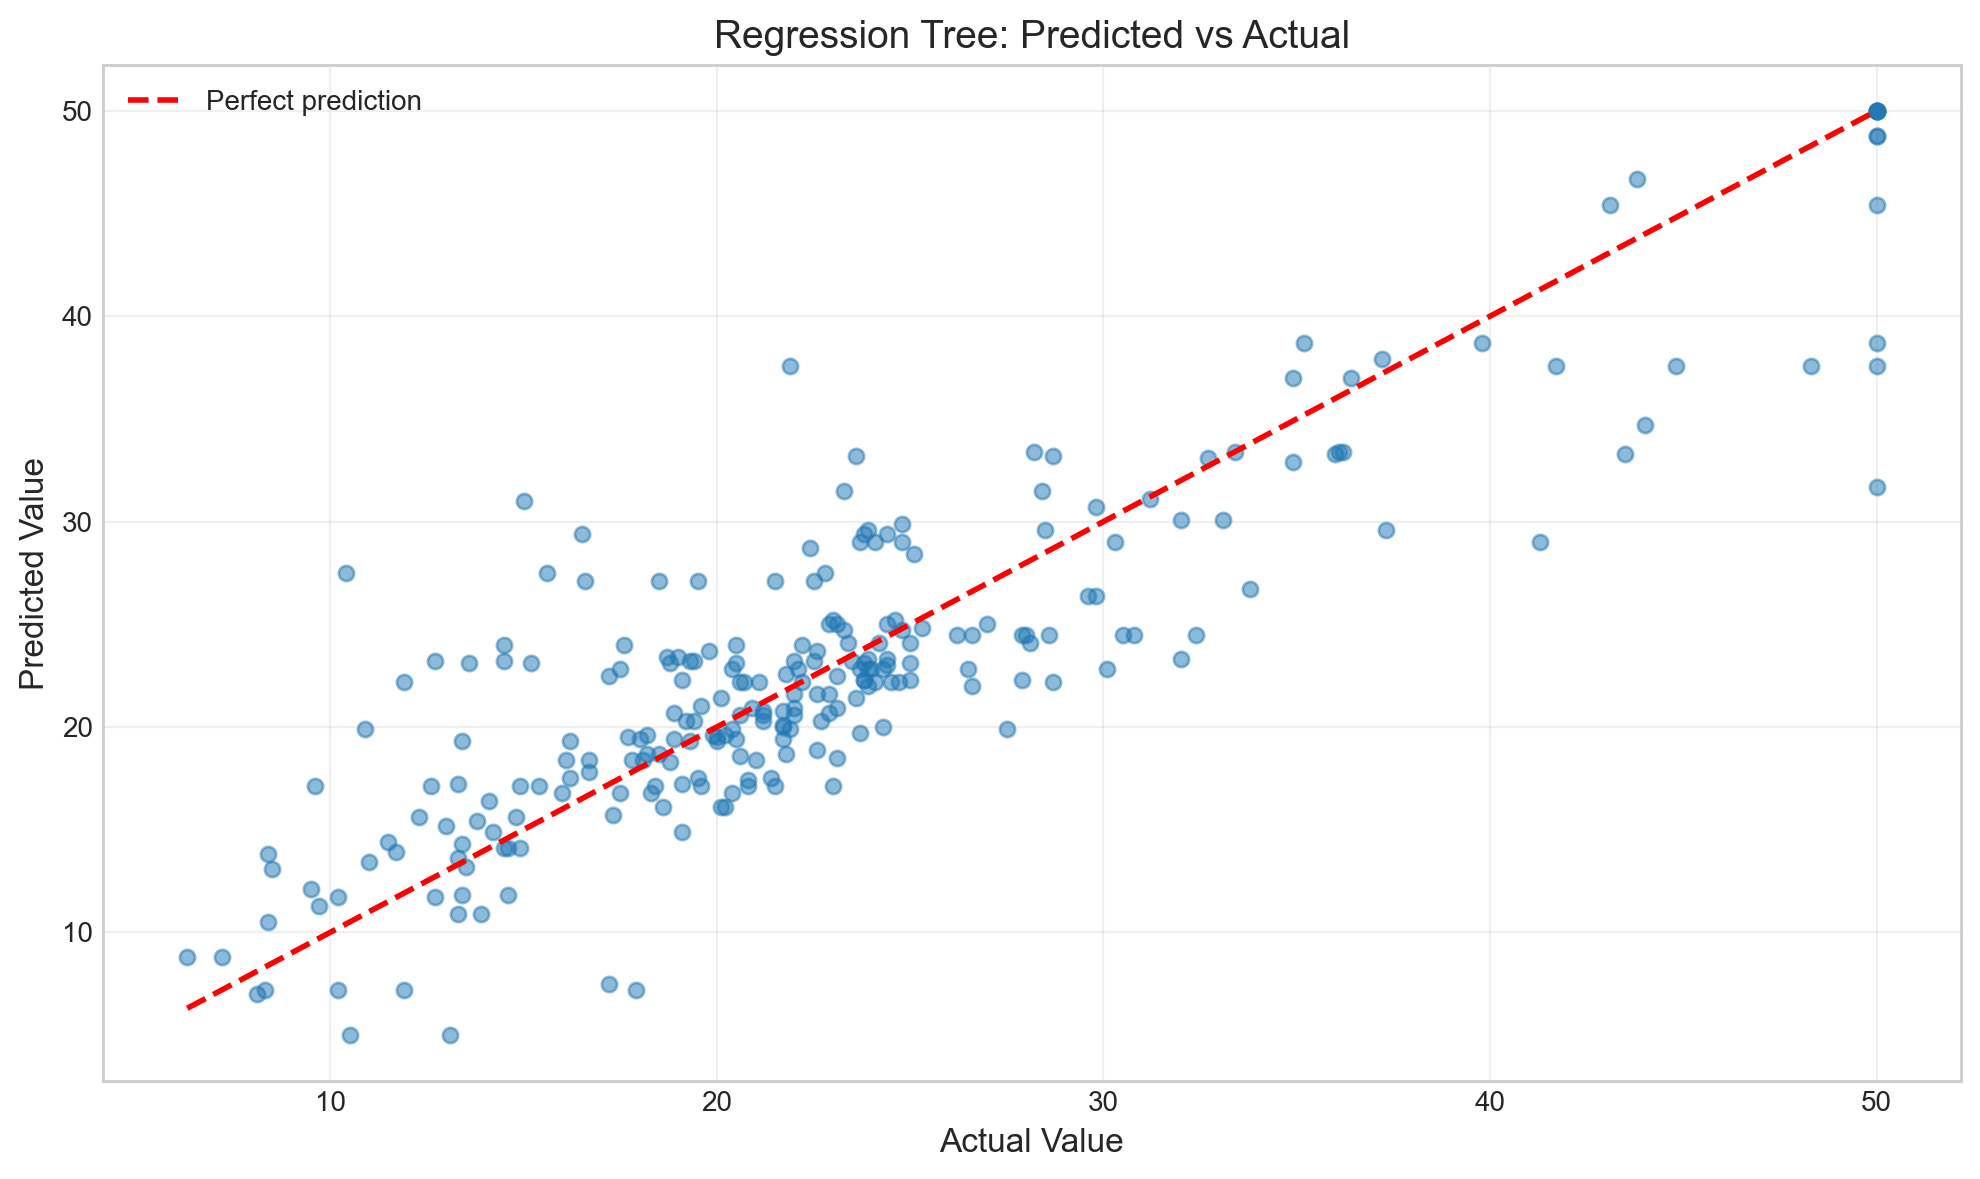

In [18]:
# Plot predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test_b, y_pred_test, alpha=0.5, s=30)
plt.plot([y_test_b.min(), y_test_b.max()], 
         [y_test_b.min(), y_test_b.max()], 
         'r--', linewidth=2, label='Perfect prediction')
plt.xlabel('Actual Value', fontsize=12)
plt.ylabel('Predicted Value', fontsize=12)
plt.title('Regression Tree: Predicted vs Actual', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

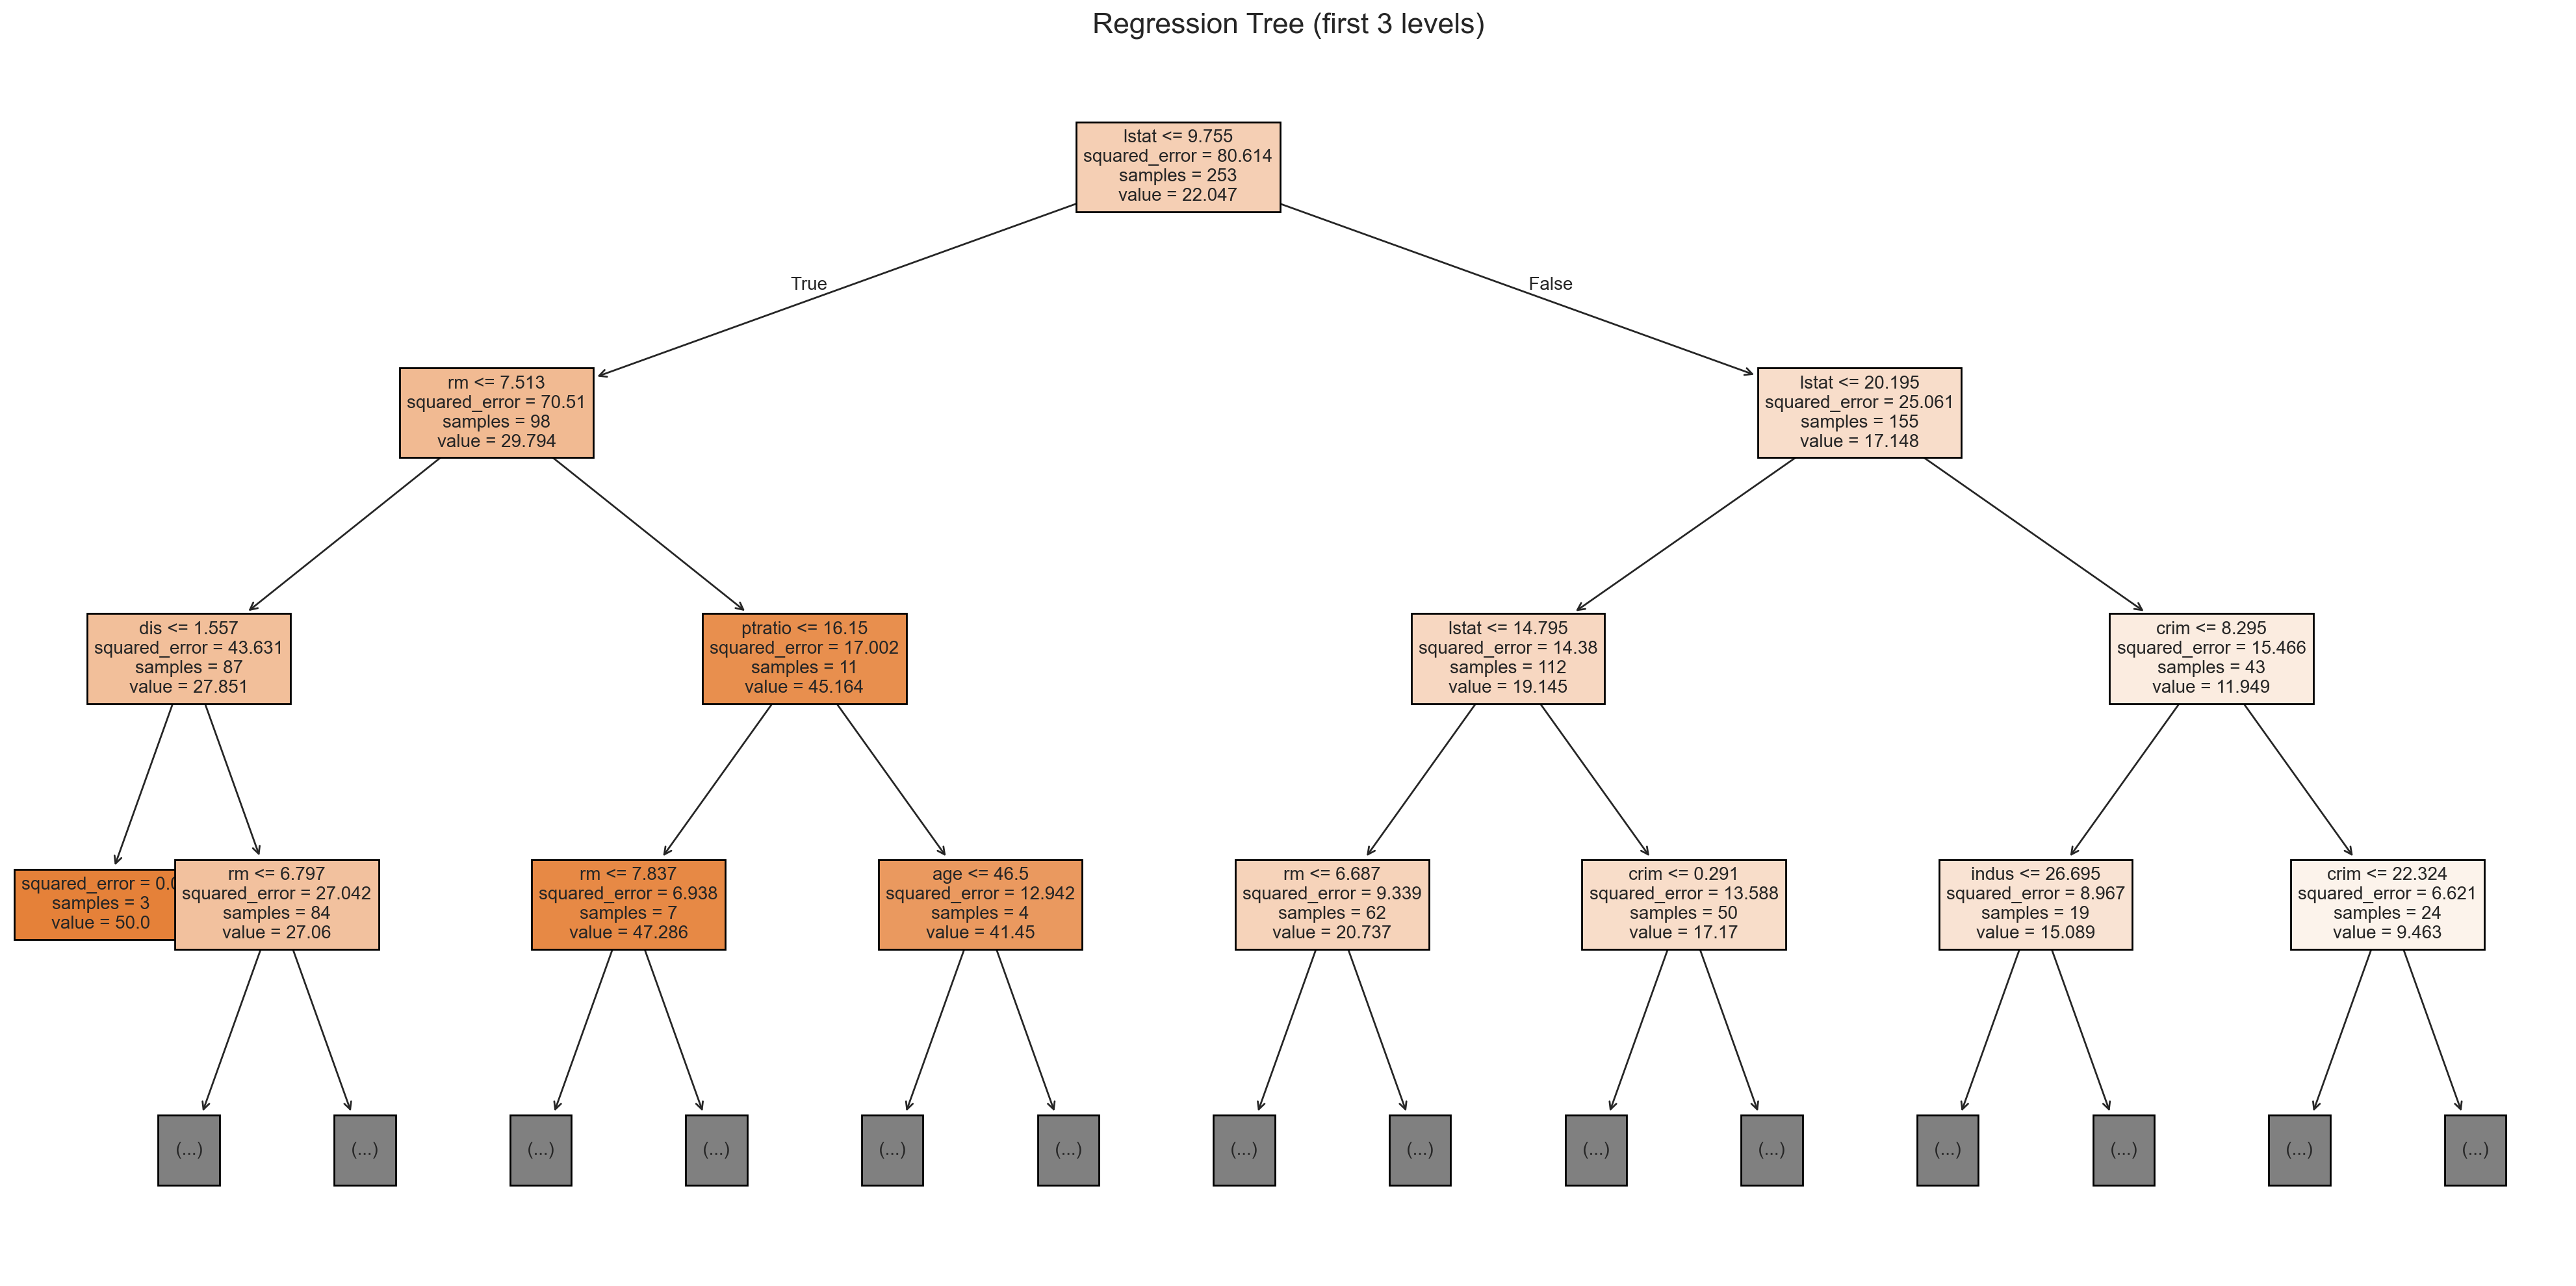

In [19]:
# Visualize regression tree (first few levels)
plt.figure(figsize=(20, 10))
plot_tree(tree_boston,
          feature_names=X_boston.columns,
          filled=True,
          fontsize=10,
          max_depth=3)  # Show only first 3 levels
plt.title('Regression Tree (first 3 levels)', fontsize=16)
plt.tight_layout()
plt.show()

### Pruning Regression Tree

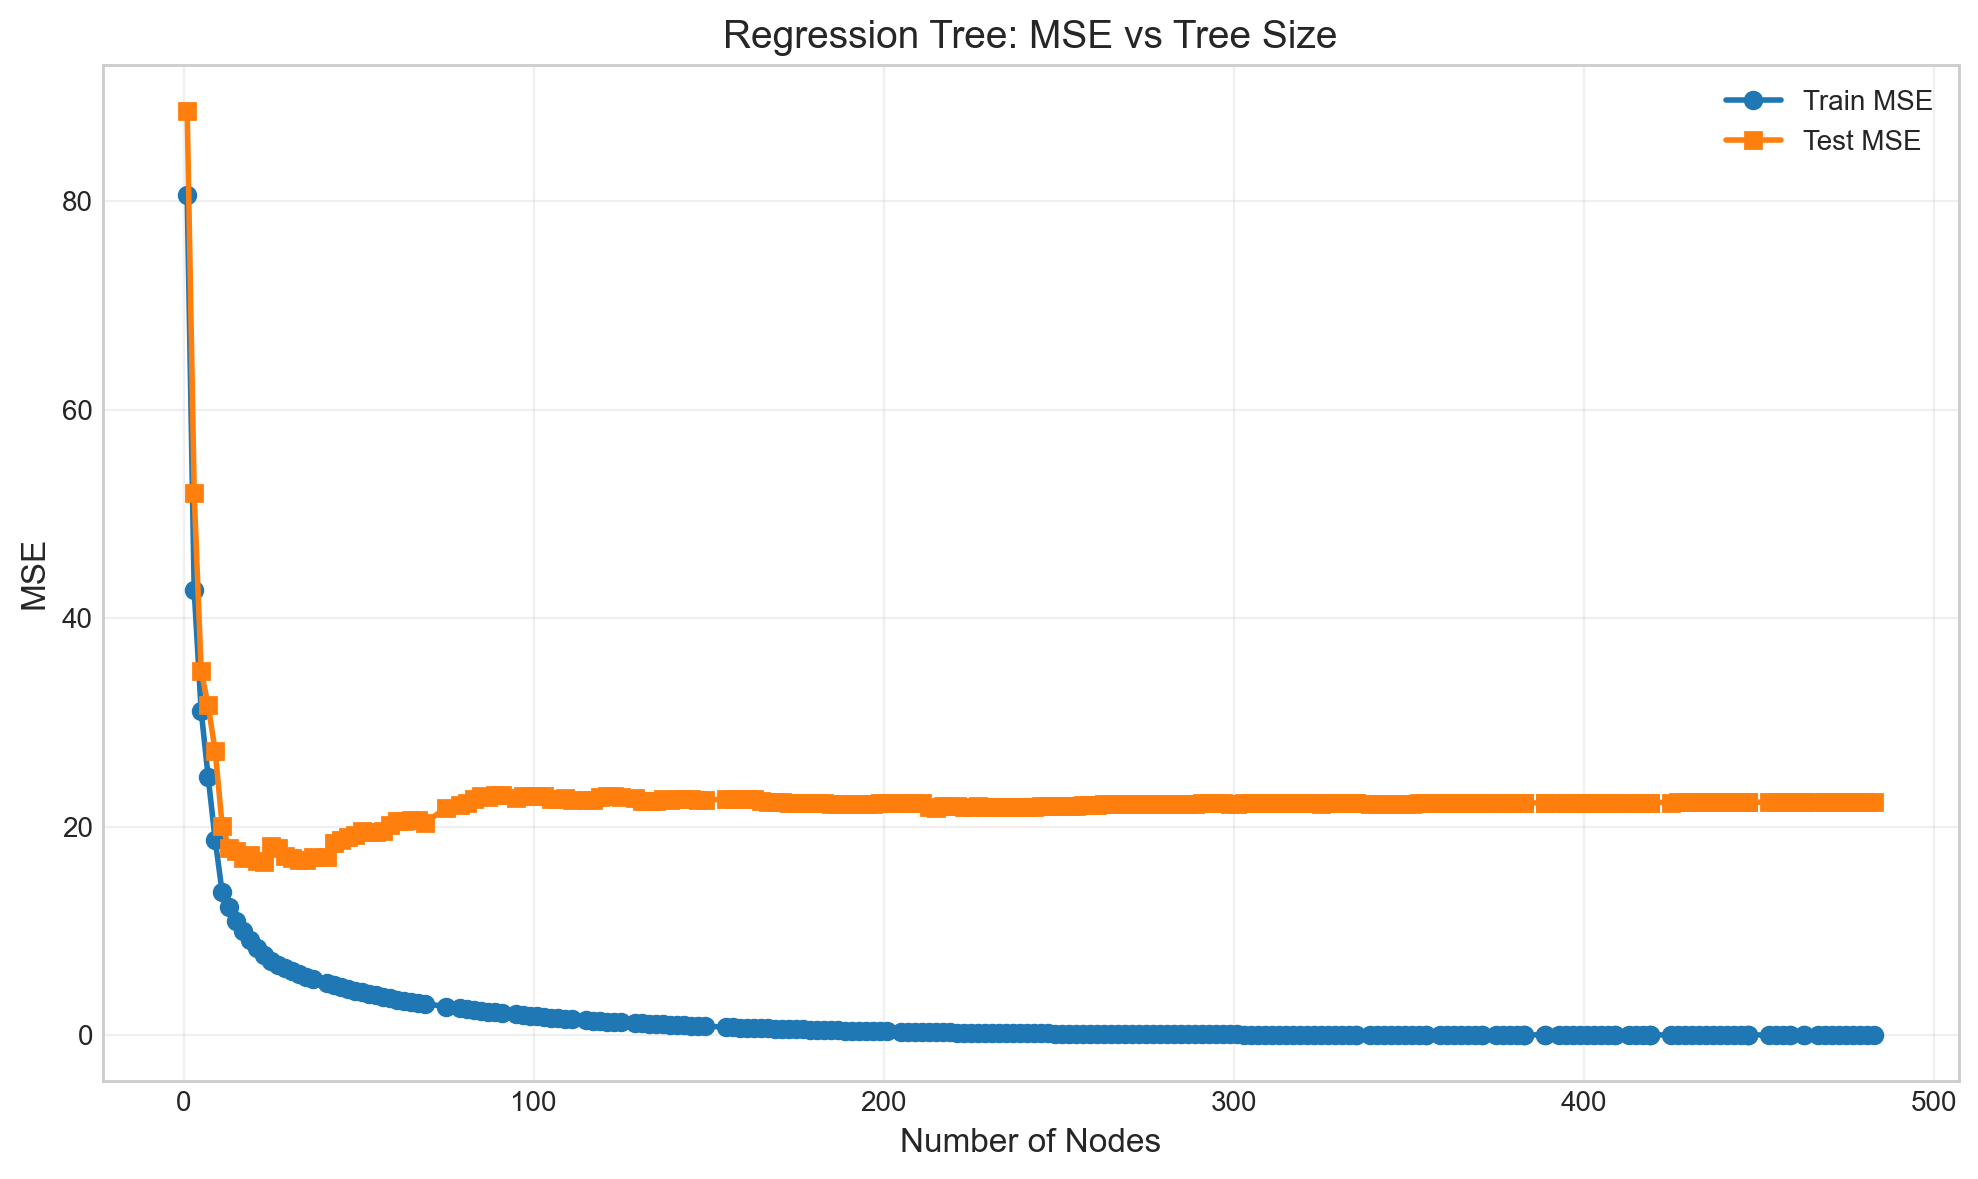

Best tree: 23 nodes, Test MSE = 16.6146


In [20]:
# Cost complexity pruning for regression tree
path_boston = tree_boston.cost_complexity_pruning_path(X_train_b, y_train_b)
ccp_alphas_boston = path_boston.ccp_alphas

# Train trees with different alphas
trees_boston = []
for ccp_alpha in ccp_alphas_boston:
    tree = DecisionTreeRegressor(random_state=1, ccp_alpha=ccp_alpha)
    tree.fit(X_train_b, y_train_b)
    trees_boston.append(tree)

# Calculate MSE for each tree
train_mses = [mean_squared_error(y_train_b, tree.predict(X_train_b)) for tree in trees_boston]
test_mses = [mean_squared_error(y_test_b, tree.predict(X_test_b)) for tree in trees_boston]
node_counts_boston = [tree.tree_.node_count for tree in trees_boston]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(node_counts_boston, train_mses, marker='o', label='Train MSE', linewidth=2)
plt.plot(node_counts_boston, test_mses, marker='s', label='Test MSE', linewidth=2)
plt.xlabel('Number of Nodes', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.title('Regression Tree: MSE vs Tree Size', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Best tree
best_idx_boston = np.argmin(test_mses)
best_mse = test_mses[best_idx_boston]
best_nodes_boston = node_counts_boston[best_idx_boston]

print(f"Best tree: {best_nodes_boston} nodes, Test MSE = {best_mse:.4f}")

## 4. Bagging (Bootstrap Aggregation)

Reduce variance by averaging many trees trained on bootstrap samples.

In [21]:
# Bagging: Random Forest with max_features = all features
# (Random Forest with mtry = p is equivalent to Bagging)
np.random.seed(1)

n_features = X_boston.shape[1]
bag_boston = RandomForestRegressor(
    n_estimators=500,
    max_features=n_features,  # Use all features (bagging)
    random_state=1,
    n_jobs=-1
)

bag_boston.fit(X_train_b, y_train_b)

print(f"Bagging with {n_features} features (all)")
print(f"Number of trees: {bag_boston.n_estimators}")

Bagging with 13 features (all)
Number of trees: 500


In [22]:
# Predictions
y_pred_bag = bag_boston.predict(X_test_b)
mse_bag = mean_squared_error(y_test_b, y_pred_bag)

print(f"\nBagging Test MSE: {mse_bag:.4f}")
print(f"Test RMSE: ${np.sqrt(mse_bag):.2f}")
print(f"\nImprovement over single tree: {((mse_test - mse_bag) / mse_test * 100):.1f}%")


Bagging Test MSE: 11.7347
Test RMSE: $3.43

Improvement over single tree: 47.5%


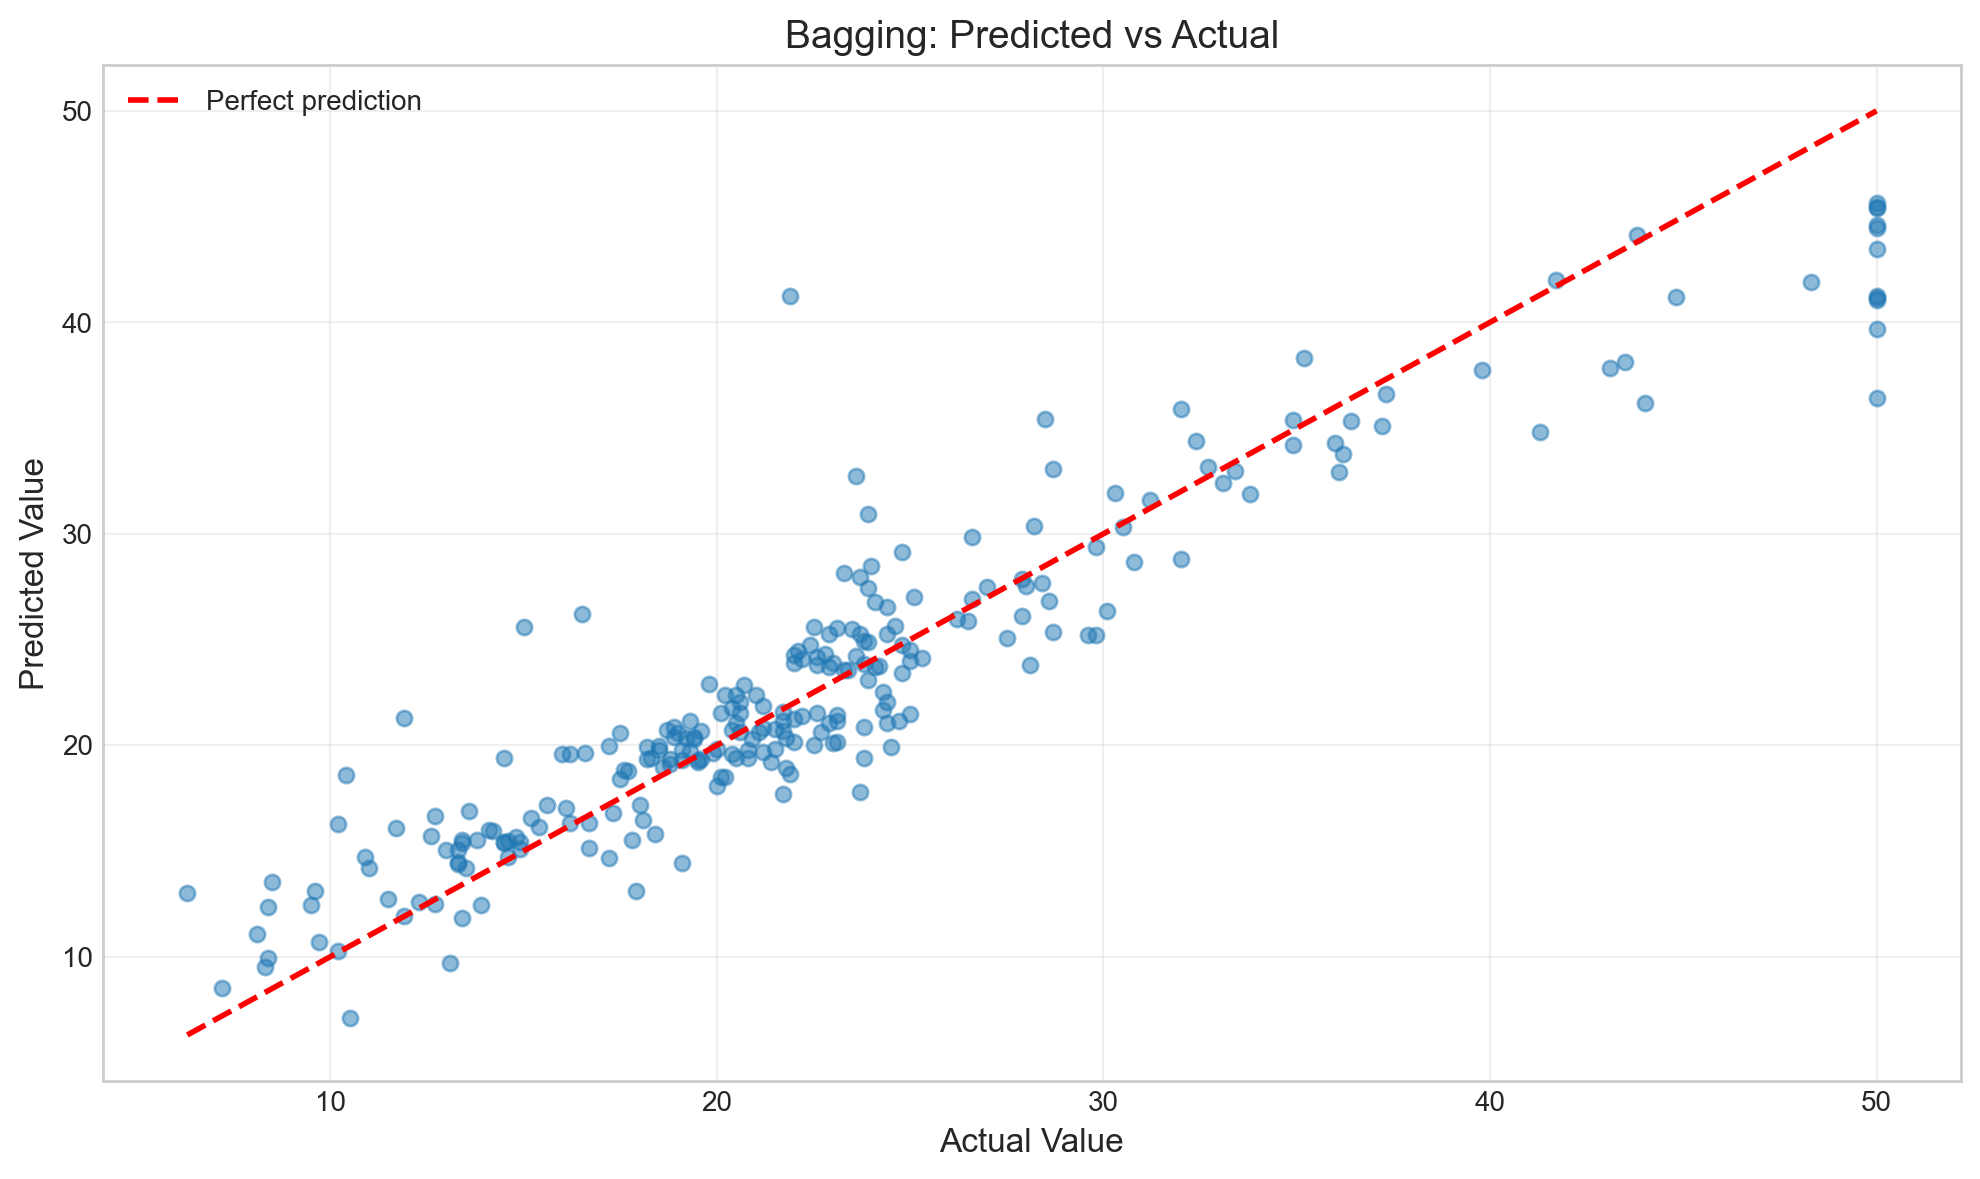

In [23]:
# Plot predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test_b, y_pred_bag, alpha=0.5, s=30)
plt.plot([y_test_b.min(), y_test_b.max()],
         [y_test_b.min(), y_test_b.max()],
         'r--', linewidth=2, label='Perfect prediction')
plt.xlabel('Actual Value', fontsize=12)
plt.ylabel('Predicted Value', fontsize=12)
plt.title('Bagging: Predicted vs Actual', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Effect of Number of Trees

n_trees=  1: MSE = 29.6385
n_trees=  5: MSE = 19.1921
n_trees= 10: MSE = 15.8523
n_trees= 25: MSE = 13.2764
n_trees= 50: MSE = 12.3567
n_trees=100: MSE = 12.0267
n_trees=200: MSE = 11.8969
n_trees=500: MSE = 11.7347


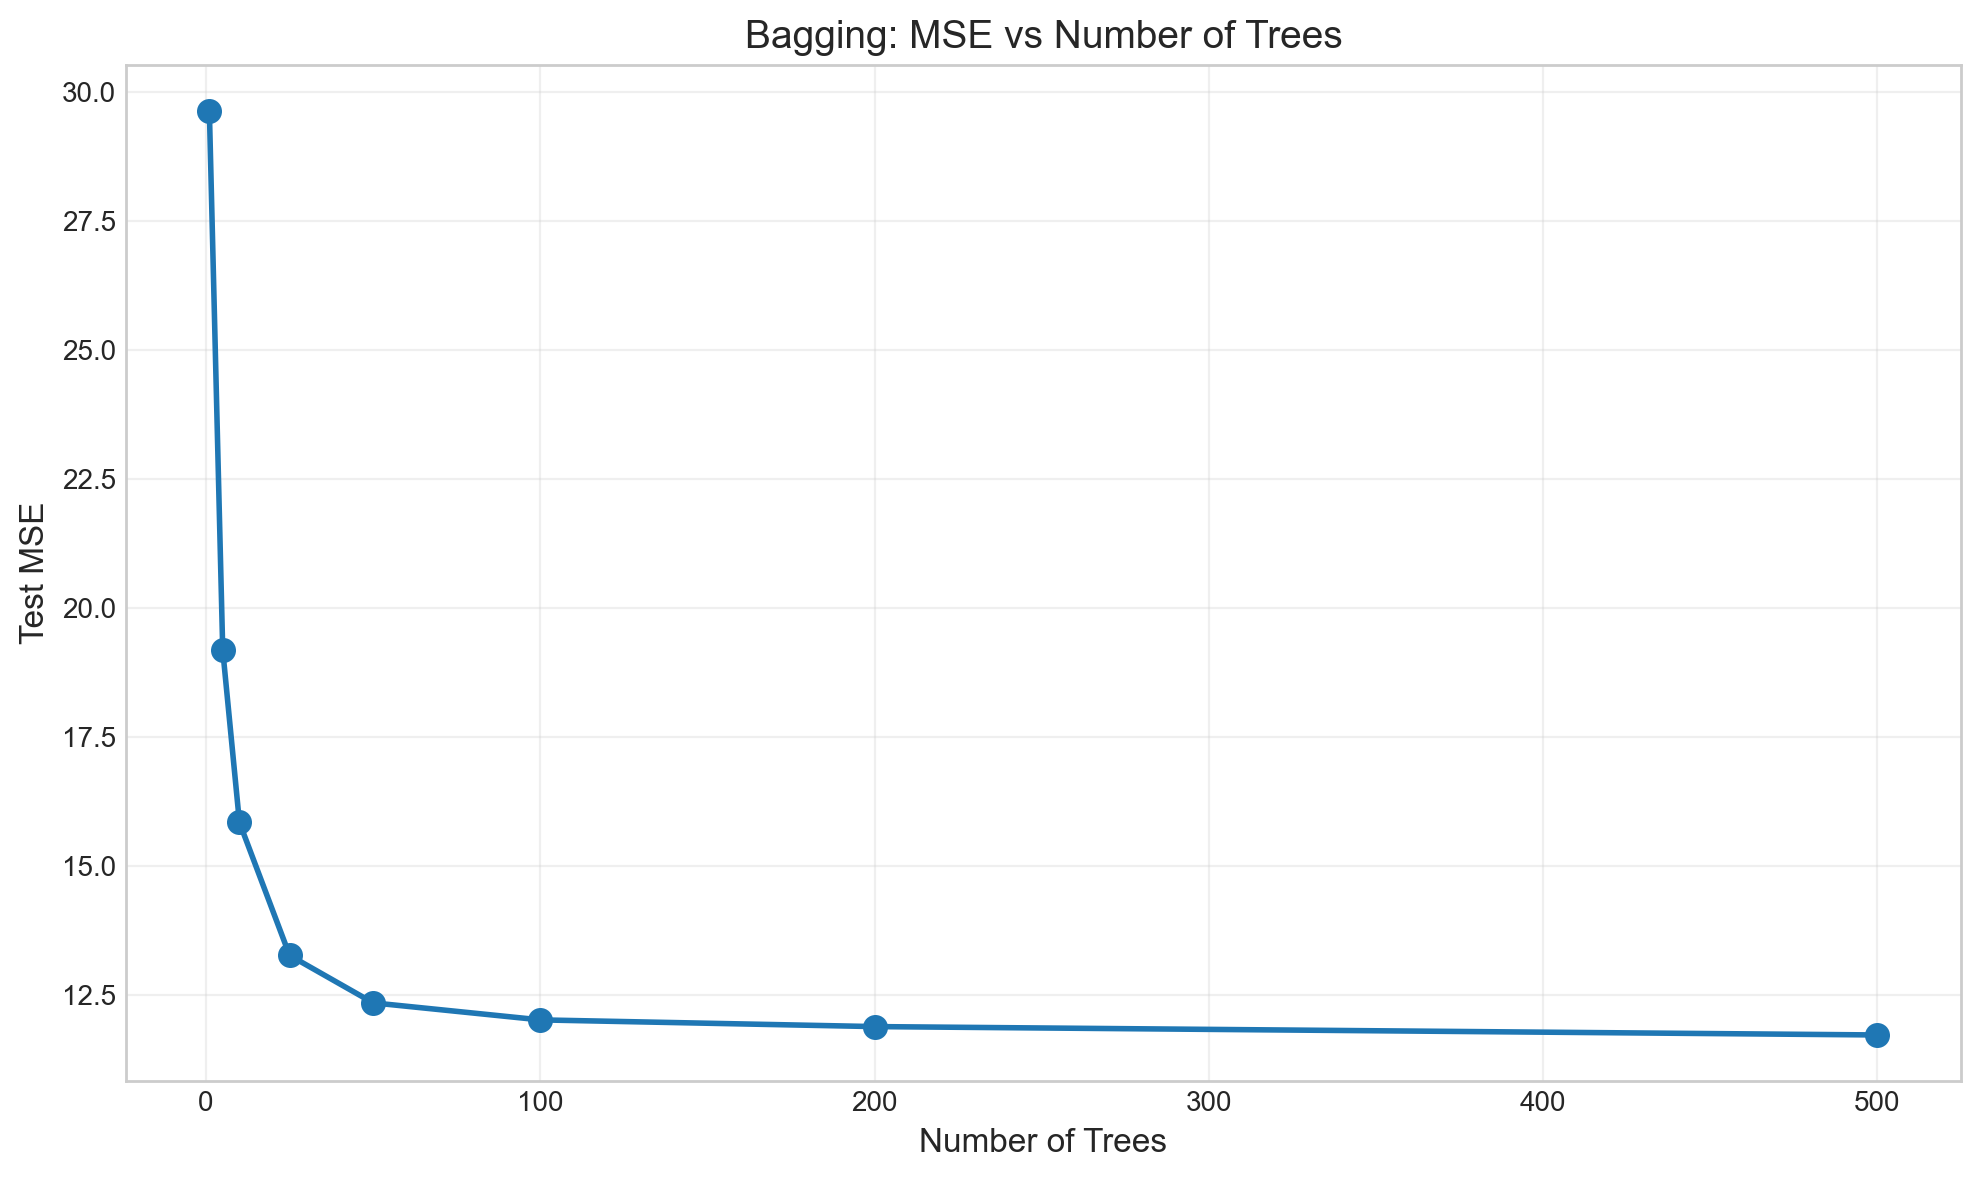


MSE stabilizes around 100-200 trees


In [24]:
# Try different numbers of trees
n_trees_list = [1, 5, 10, 25, 50, 100, 200, 500]
mses_by_ntrees = []

for n_trees in n_trees_list:
    bag = RandomForestRegressor(
        n_estimators=n_trees,
        max_features=n_features,
        random_state=1,
        n_jobs=-1
    )
    bag.fit(X_train_b, y_train_b)
    y_pred = bag.predict(X_test_b)
    mse = mean_squared_error(y_test_b, y_pred)
    mses_by_ntrees.append(mse)
    print(f"n_trees={n_trees:3d}: MSE = {mse:.4f}")

# Plot
plt.figure(figsize=(10, 6))
plt.plot(n_trees_list, mses_by_ntrees, marker='o', linewidth=2, markersize=8)
plt.xlabel('Number of Trees', fontsize=12)
plt.ylabel('Test MSE', fontsize=12)
plt.title('Bagging: MSE vs Number of Trees', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nMSE stabilizes around 100-200 trees")

## 5. Random Forests

Use a random subset of features at each split to decorrelate trees.

In [25]:
# Random Forest with mtry = sqrt(p) for regression
np.random.seed(1)

# For regression, typically use p/3 features
max_features_rf = max(1, n_features // 3)

rf_boston = RandomForestRegressor(
    n_estimators=500,
    max_features=max_features_rf,
    random_state=1,
    n_jobs=-1
)

rf_boston.fit(X_train_b, y_train_b)

print(f"Random Forest with {max_features_rf} features (p/3)")
print(f"Number of trees: {rf_boston.n_estimators}")

Random Forest with 4 features (p/3)
Number of trees: 500


In [26]:
# Predictions
y_pred_rf = rf_boston.predict(X_test_b)
mse_rf = mean_squared_error(y_test_b, y_pred_rf)

print(f"\nRandom Forest Test MSE: {mse_rf:.4f}")
print(f"Test RMSE: ${np.sqrt(mse_rf):.2f}")
print(f"\nComparison:")
print(f"  Single Tree MSE: {mse_test:.4f}")
print(f"  Bagging MSE: {mse_bag:.4f}")
print(f"  Random Forest MSE: {mse_rf:.4f}")


Random Forest Test MSE: 12.1880
Test RMSE: $3.49

Comparison:
  Single Tree MSE: 22.3351
  Bagging MSE: 11.7347
  Random Forest MSE: 12.1880


### Variable Importance

In [27]:
# Feature importance
importances = rf_boston.feature_importances_
indices = np.argsort(importances)[::-1]

# Create DataFrame
importance_df = pd.DataFrame({
    'Feature': X_boston.columns,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print("Feature Importance:")
print(importance_df.to_string(index=False))

Feature Importance:
Feature  Importance
  lstat    0.309659
     rm    0.234158
  indus    0.086251
   crim    0.076739
    dis    0.067994
    nox    0.067312
ptratio    0.054179
    age    0.035256
      b    0.025492
    tax    0.023584
    rad    0.008464
     zn    0.008388
   chas    0.002524


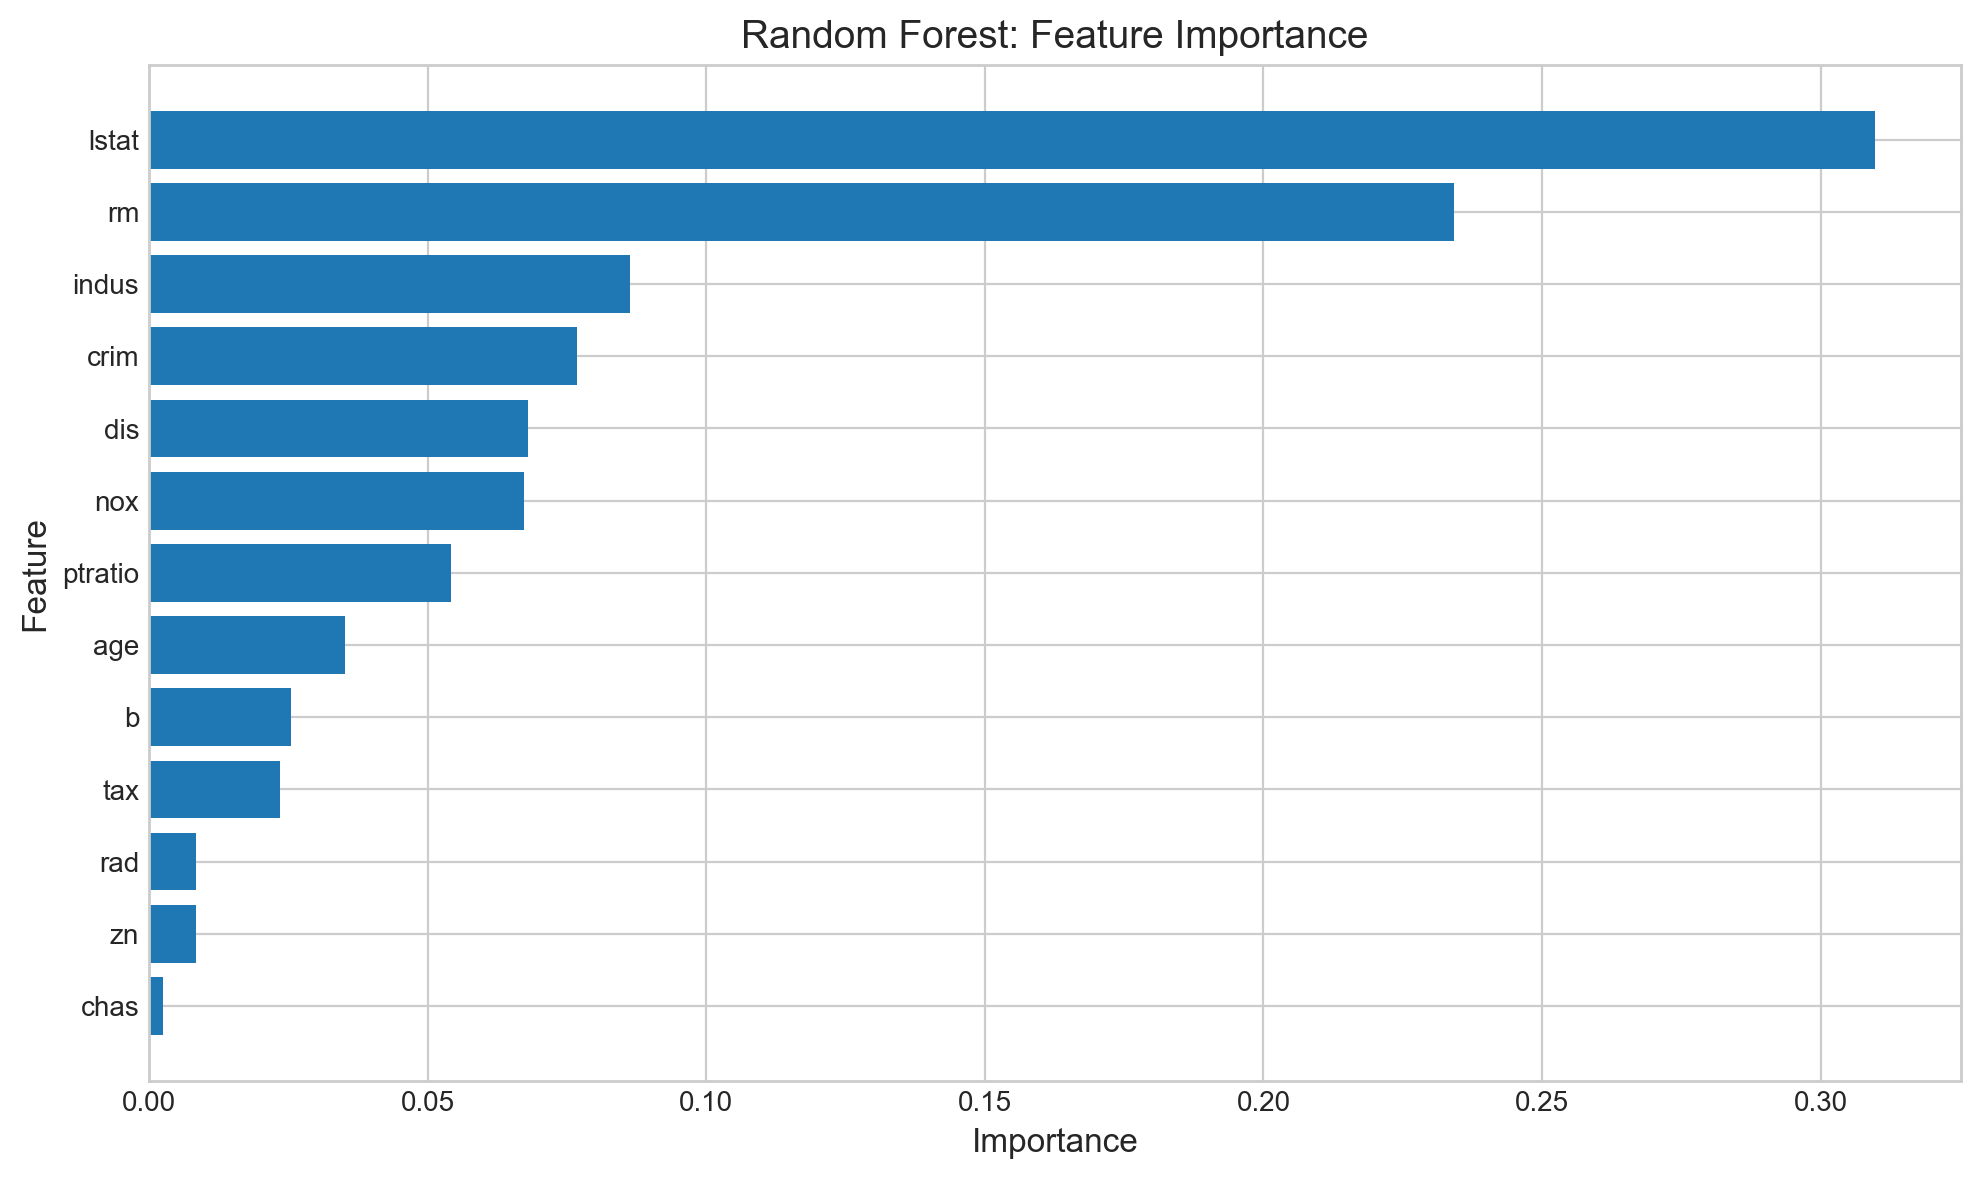


Most important features:
  1. lstat: 0.3097
  2. rm: 0.2342
  3. indus: 0.0863
  4. crim: 0.0767
  5. dis: 0.0680


In [28]:
# Variable importance plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances[indices], align='center')
plt.yticks(range(len(importances)), X_boston.columns[indices])
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Random Forest: Feature Importance', fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\nMost important features:")
for i in range(min(5, len(importance_df))):
    print(f"  {i+1}. {importance_df.iloc[i]['Feature']}: {importance_df.iloc[i]['Importance']:.4f}")

## 6. Boosting (Gradient Boosting)

Build trees sequentially, each correcting errors from previous trees.

In [29]:
# Gradient Boosting
np.random.seed(1)

boost_boston = GradientBoostingRegressor(
    n_estimators=5000,
    learning_rate=0.01,  # shrinkage parameter (lambda)
    max_depth=4,  # interaction depth
    random_state=1
)

boost_boston.fit(X_train_b, y_train_b)

print(f"Gradient Boosting:")
print(f"Number of trees: {boost_boston.n_estimators}")
print(f"Learning rate: {boost_boston.learning_rate}")
print(f"Max depth: {boost_boston.max_depth}")

Gradient Boosting:
Number of trees: 5000
Learning rate: 0.01
Max depth: 4


In [30]:
# Predictions
y_pred_boost = boost_boston.predict(X_test_b)
mse_boost = mean_squared_error(y_test_b, y_pred_boost)

print(f"\nGradient Boosting Test MSE: {mse_boost:.4f}")
print(f"Test RMSE: ${np.sqrt(mse_boost):.2f}")

print(f"\nFinal Comparison:")
print(f"  Single Tree MSE: {mse_test:.4f}")
print(f"  Bagging MSE: {mse_bag:.4f}")
print(f"  Random Forest MSE: {mse_rf:.4f}")
print(f"  Gradient Boosting MSE: {mse_boost:.4f}")

best_method = min(
    [('Single Tree', mse_test), ('Bagging', mse_bag), 
     ('Random Forest', mse_rf), ('Boosting', mse_boost)],
    key=lambda x: x[1]
)
print(f"\nBest method: {best_method[0]} (MSE = {best_method[1]:.4f})")


Gradient Boosting Test MSE: 10.1921
Test RMSE: $3.19

Final Comparison:
  Single Tree MSE: 22.3351
  Bagging MSE: 11.7347
  Random Forest MSE: 12.1880
  Gradient Boosting MSE: 10.1921

Best method: Boosting (MSE = 10.1921)


In [31]:
# Feature importance for boosting
importances_boost = boost_boston.feature_importances_
importance_boost_df = pd.DataFrame({
    'Feature': X_boston.columns,
    'Importance': importances_boost
}).sort_values('Importance', ascending=False)

print("\nGradient Boosting Feature Importance:")
print(importance_boost_df.to_string(index=False))


Gradient Boosting Feature Importance:
Feature  Importance
  lstat    0.579038
     rm    0.220504
    dis    0.085361
   crim    0.028538
ptratio    0.018043
    tax    0.017513
    nox    0.014979
    age    0.013585
      b    0.012257
  indus    0.006763
    rad    0.002174
   chas    0.001114
     zn    0.000131


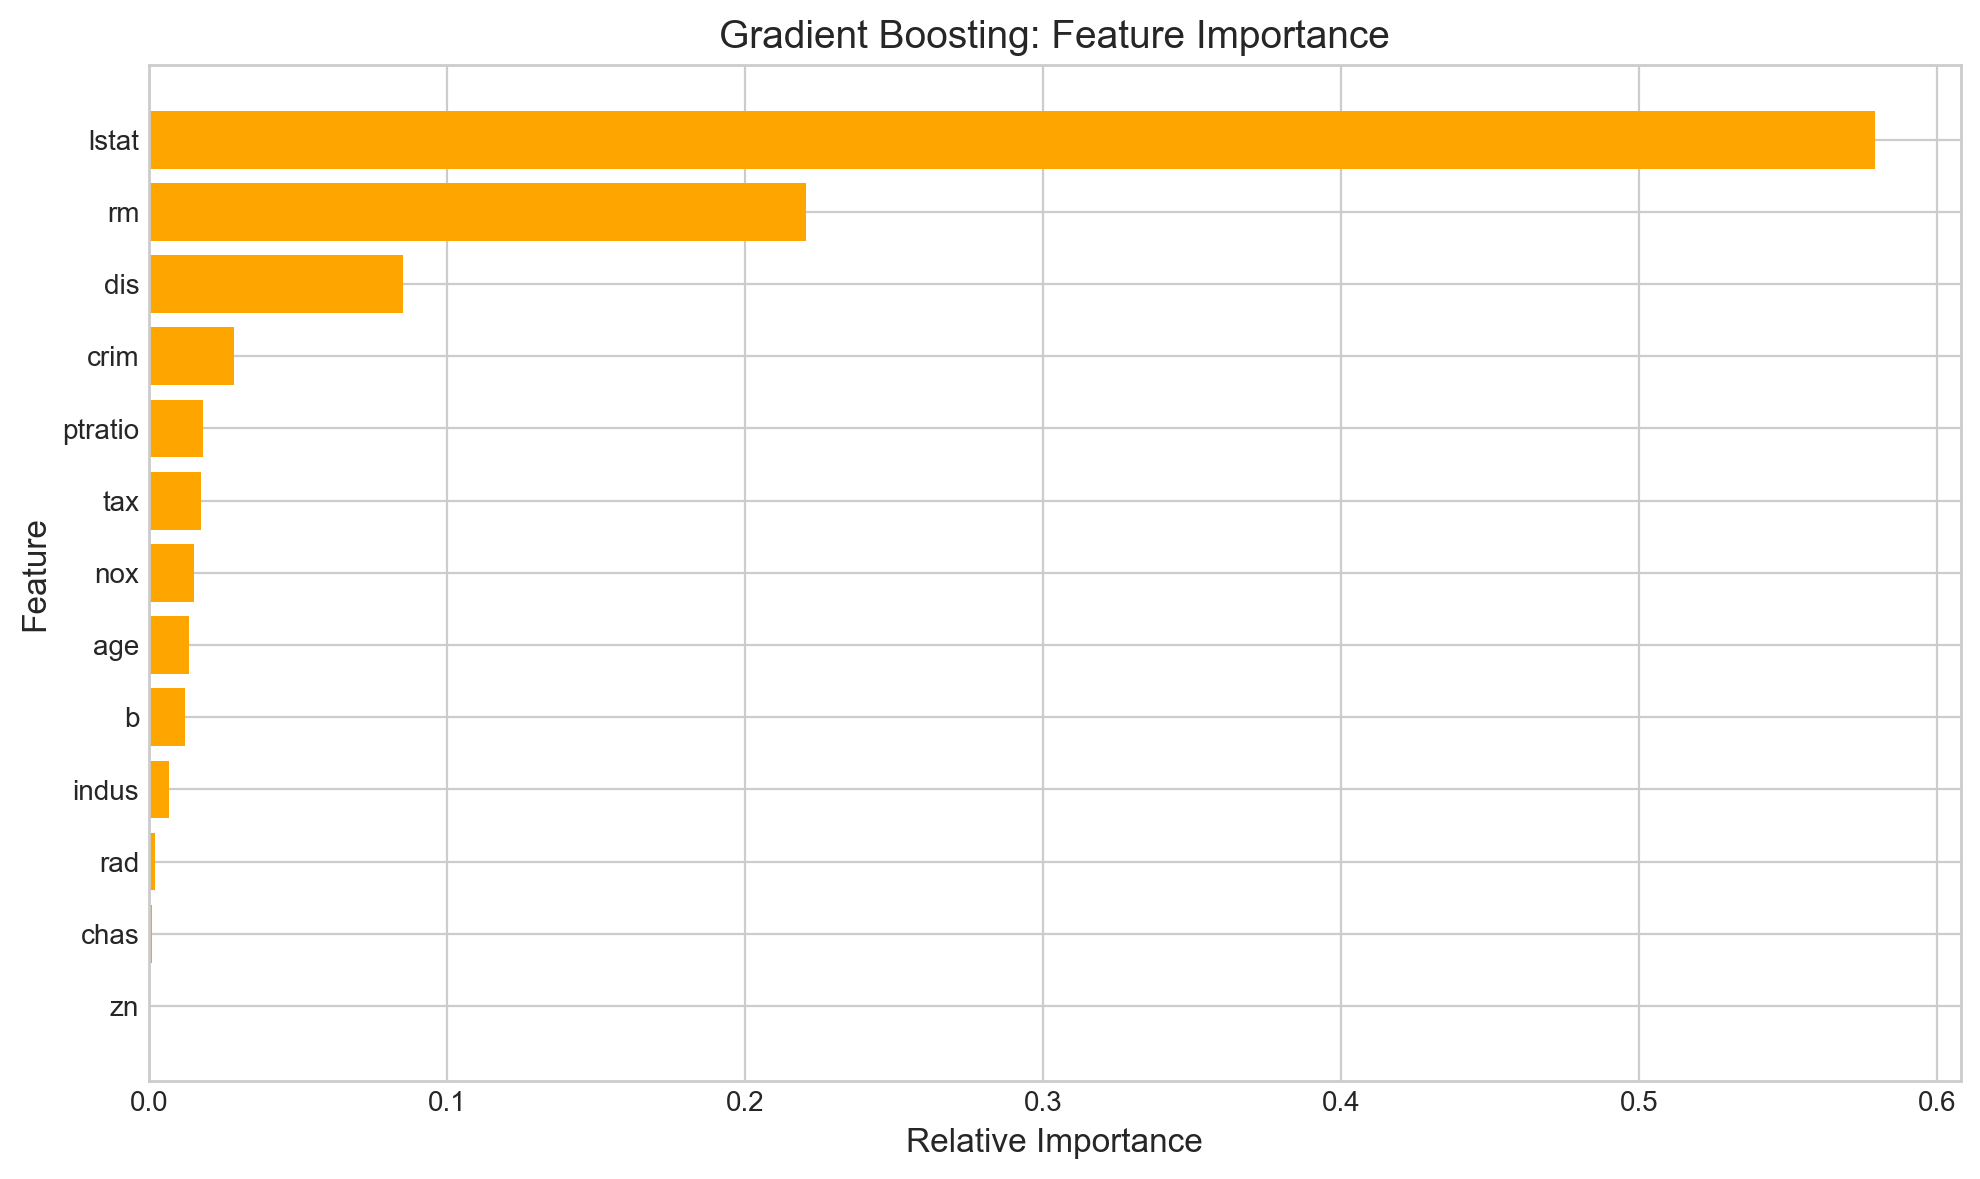

In [32]:
# Variable importance plot for boosting
indices_boost = np.argsort(importances_boost)[::-1]

plt.figure(figsize=(10, 6))
plt.barh(range(len(importances_boost)), importances_boost[indices_boost], align='center', color='orange')
plt.yticks(range(len(importances_boost)), X_boston.columns[indices_boost])
plt.xlabel('Relative Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Gradient Boosting: Feature Importance', fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Effect of Learning Rate (Shrinkage)

Learning rate=0.001: MSE = 10.6734
Learning rate=0.010: MSE = 10.1921
Learning rate=0.050: MSE = 10.2240
Learning rate=0.100: MSE = 10.3542
Learning rate=0.200: MSE = 10.0611


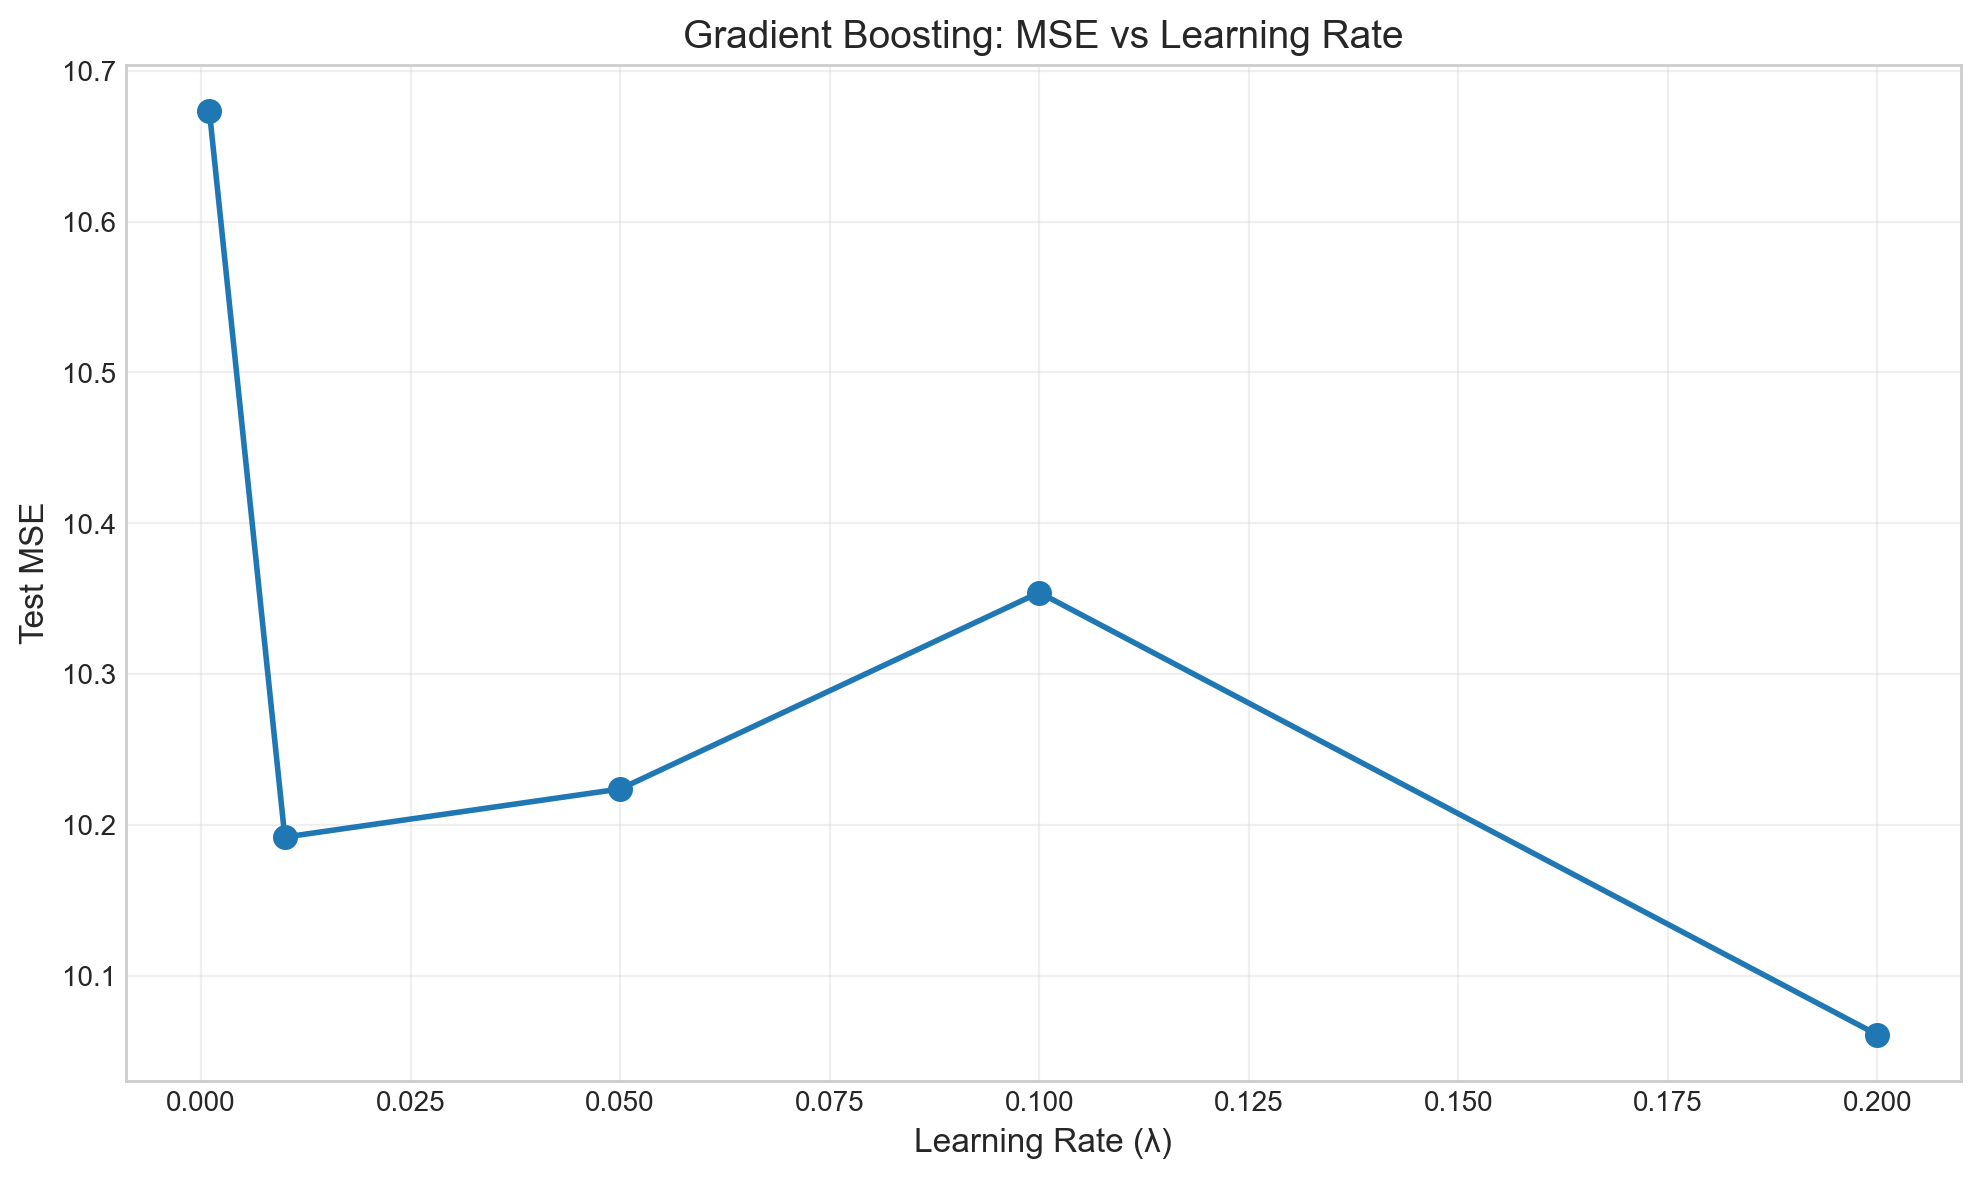


Best learning rate: 0.2


In [33]:
# Try different learning rates
learning_rates = [0.001, 0.01, 0.05, 0.1, 0.2]
mses_by_lr = []

for lr in learning_rates:
    boost = GradientBoostingRegressor(
        n_estimators=5000,
        learning_rate=lr,
        max_depth=4,
        random_state=1
    )
    boost.fit(X_train_b, y_train_b)
    y_pred = boost.predict(X_test_b)
    mse = mean_squared_error(y_test_b, y_pred)
    mses_by_lr.append(mse)
    print(f"Learning rate={lr:.3f}: MSE = {mse:.4f}")

# Plot
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, mses_by_lr, marker='o', linewidth=2, markersize=8)
plt.xlabel('Learning Rate (λ)', fontsize=12)
plt.ylabel('Test MSE', fontsize=12)
plt.title('Gradient Boosting: MSE vs Learning Rate', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

best_lr = learning_rates[np.argmin(mses_by_lr)]
print(f"\nBest learning rate: {best_lr}")

## Summary

This notebook covered:

### **Decision Trees**
- **Classification Trees**: Binary splits based on features
- **Regression Trees**: Predict continuous values
- **Advantages**: Easy to interpret, handle non-linear relationships
- **Disadvantages**: High variance, prone to overfitting

### **Tree Pruning**
- **Cost Complexity Pruning**: Trade-off between tree size and fit
- **Cross-Validation**: Select optimal tree size
- **Result**: Simpler trees that generalize better

### **Bagging**
- **Bootstrap Aggregation**: Average many trees trained on bootstrap samples
- **Reduces variance** while maintaining low bias
- **Out-of-Bag Error**: Built-in cross-validation estimate

### **Random Forests**
- **Decorrelated Trees**: Use random subset of features at each split
- **mtry parameter**: Typically √p for classification, p/3 for regression
- **Feature Importance**: Which variables matter most
- **Generally better** than bagging

### **Boosting**
- **Sequential Learning**: Each tree corrects previous errors
- **Shrinkage (λ)**: Learning rate controls contribution of each tree
- **Interaction Depth**: Maximum depth of each tree
- **Often best performance** but slower to train

### **Key Takeaways**
- Single trees: High variance, overfit
- Bagging: Reduces variance (parallel)
- Random Forests: Further reduces variance via decorrelation
- Boosting: Reduces bias and variance (sequential)
- **Trade-off**: Interpretability vs Performance
  - Single tree: Very interpretable
  - Ensembles: Better performance, less interpretable
- **Use feature importance** to understand ensemble models